# import

In [35]:
from ast import literal_eval
import json
import os
import pandas as pd
import numpy as np
import ast 
from matplotlib import pyplot as plt
import shutil

def find_awake_ppseq_base_path(mir,awake_ppseq_path):
    awake_ppseq_mirs = np.array(['_'.join(item.split('_')[0:3]) for item in os.listdir(awake_ppseq_path)])
    awake_file_mir = None
    for ind,item in enumerate(awake_ppseq_mirs):
        if item in mir:
            awake_file_mir = os.listdir(awake_ppseq_path)[ind]
    if awake_file_mir == None:
        return None
    else:
        return(os.path.join(awake_ppseq_path,awake_file_mir))

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def create_multicluster_dataframe(filtered_chunk_data):
    meaned_order = []
    fs_order = []
    event_times = []
    count = 0
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            means = []
            event_types = []
            fs_orders = []
            for index,events in enumerate(current_cluster.cluster_spike_times):
                event_types += [current_cluster.cluster_seq_type.values[index]]
                # calculate event order based on spike time weighted mean
                means += [np.mean(ast.literal_eval(events))]
                # calculate order based on first spike time:
                fs_orders += [current_cluster.first_spike_time.values[index]]

            # order by mean time:    
            meaned_order += [list(np.array(event_types)[np.argsort(means)])]
            # order by first spike:
            fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

            event_times += [fs_orders]

            current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
            current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
            current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

            if count == 0:
                multi_cluster_df = current_cluster.copy()
            else:
                # Concatenate the DataFrames vertically (row-wise)
                multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                # Reset the index if needed
                multi_cluster_df = multi_cluster_df.reset_index(drop=True)

            count += 1
    return multi_cluster_df,meaned_order,fs_order

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def refind_cluster_events(filtered_chunk_data,event_proximity_filter):
    
    ### ignore the origonal clusterg rosp and remake them: 
    start_times = filtered_chunk_data.first_spike_time.values
    end_times = filtered_chunk_data.last_spike_time.values

    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

    cluster_group = np.zeros(len(filtered_chunk_data))
    for index,cluster in enumerate(clustered_events):
        for item in cluster:
            cluster_group[item] = int(index)
    filtered_chunk_data['coactive_cluster_group'] = cluster_group
    
    return filtered_chunk_data

def find_data_paths(all_mice_dict,sleep_path):
    for i,file in enumerate(os.listdir(sleep_path)):
        print(i)
        if 'run' in file:
            paths_dict = {}
            mir = file.split('run')[0][0:-1]
            paths_dict['sleep_path'] = sleep_path + file
            awake_base = os.path.join(remove_last_folder(sleep_path), 'awake')
            for awake_file in os.listdir(awake_base):
                if mir in awake_file:
                    paths_dict['awake_path'] = os.path.join(awake_base, awake_file)
            try: 
                paths_dict['full_org_dat_path'] = find_organised_path('EJT' + mir,r"Z:\projects\sequence_squad\organised_data\animals\\")
            except:
                paths_dict['full_org_dat_path']  = find_organised_path(mir,r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\")
            all_mice_dict[mir] = paths_dict
    return all_mice_dict

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times

def reactivation_per_minute(nrem_filtered_chunk_data, nrem_state_times):
    # save out data
    reactivations_found = len(nrem_filtered_chunk_data)

    if len(nrem_state_times) > 0:
        mins = np.diff(nrem_state_times)
    else:
        mins = 0
        
    # convert to mins            
    mins = mins/60

    if mins > 0:
        return reactivations_found/mins
    else:
        return np.nan
    
def find_coactive_pair_rate(chunk_data_clusters,seq_id):
    coactive_clusts = 0
    total = 0
    for index,item_group in enumerate(chunk_data_clusters.coactive_cluster_group):
        if chunk_data_clusters.cluster_seq_type[index] == seq_id+1:
            full_group = np.where(chunk_data_clusters.coactive_cluster_group == item_group)[0]
            if len(full_group) > 1:
                coactive_clusts += 1
            total += 1
    if total > 0:
        return coactive_clusts,total
    else:
        return np.nan,np.nan
    

import pickle

def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def split_sequence_events(seq_event_dfs):
    # Split sequence events into a dictionary by sequence type.
    # Each key is the sequence type, and the value is a list of DataFrames for those events
    seq_events = {}
    for event in seq_event_dfs:
        # add the sequence type as a key if it doesn't exist
        if str(int(event.sequence_type_adjusted.values[0])) not in seq_events:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))] = [event]
        else:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))].append(event)
    return seq_events

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups


def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted

def calcuate_neuron_consistency(seq_id, unmasked_spikes_df, seq_events_dict):
    """
    Calculate the proportion of times each neuron appears in the sequence events for a given sequence type.
    """
    proportion_appeared = [] 
    neurons_appeared = []
    for neuron_id in unmasked_spikes_df.neuron.unique():
        appears = 0
        for event in seq_events_dict[str(seq_id)]:
            if neuron_id in event.neuron.values:
                appears += 1      
        if appears > 0:
            total_events = len(seq_events_dict[str(seq_id)])
            proportion_appeared += [appears/total_events]
            neurons_appeared += [neuron_id]   
    return proportion_appeared,neurons_appeared
                    
### spindle filtering!
#compute a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms)

# We computed a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms). 
# Next, we determined two thresholds for spindle detection based on the mean (μ) and standard deviation (σ) of the spindle band envelope during NREM sleep; 
# the upper and lower thresholds were set μ + 2.5 × σ and μ + 1.5 × σ, respectively. Epochs in which the spindle power exceeded the upper threshold for at least one sample 
# and the spindle power exceeded the lower threshold for at least 500 ms were considered spindles. 
# Each epoch where the spindle power exceeded the lower threshold was considered the start and stop of the spindle; the duration of each spindle was based on these values as well. 
# For the reactivation analyses spindles was detected in 13-16 Hz based on the previous finding that fast spindles (13-16 Hz) play a key role for sleep-dependent memory reactivation

from scipy.signal import hilbert, convolve


def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def define_spindle_linkage(spindle_start_events,spindle_end_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for i,spin_start in enumerate(spindle_start_events):
            s_distance = abs(spin_start - event)
            e_distance = abs(spindle_end_events[i] - event)
            if s_distance < abs(current_shortest_dist):
                current_shortest_dist = s_distance
            elif e_distance < abs(current_shortest_dist):
                current_shortest_dist = e_distance
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

In [2]:
# features 

# motif rate per min 
# motif relative event rate 
# motif relative proportion 
# motif spikes per event
# motif units per event
# motif event lengths
# motif proportion coactive
# motif proportion appearing in ordered coative pairs
# motif overall neuron spiking consistency - are the neurons that we saw in replay on average consistently in or not in awake replay?
# motif average warp factor
# motif forward vs reverse replay ratio 
# motif proportion spindle linked / distance to closest spindle 

# replay processing loop

EJT136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
full_org_dat_path: Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
Loading sleep data from: Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\replay_data\\136_1_3_run_1007023_2048
----------
EJT136_1_3
0
Awake PPSeq base path: Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\136_1_3_run_2701023_1835
chunk1_8700to9300
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_10000to11600
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_11900to12500
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:356: RuntimeWarning: Mean of empty slice
  seq_event_lens += [np.nanmean([item for sublist in [item[i] for item in chunk_event_lens] for item in sublist])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:385: RuntimeWarning: Mean of empty slice
  mean_spikes_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_spikes_chunk] for item in sublist])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:386: RuntimeWarning: Mean of empty slice
  mean_neurons_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_neurons_chunk] for item in sublist])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:422: RuntimeWarning: Mean of empty slice
  replay_neuron_awake_consistency_per_motif += [np.nanmean(consistency_score)]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:431: RuntimeWarning: Mea

_______________________________________________________________________________________________
Saved replay features for EJT136_1_3
_______________________________________________________________________________________________
EJT178_2_3
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant2
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant2\recording3_06-04-2022
full_org_dat_path: Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant2\recording3_06-04-2022
Loading sleep data from: Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\replay_data\\178_2_3_run_2006023_2004
----------
EJT178_2_3
1
Awake PPSeq base path: Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\178_2_3_run_2701023_1532
chunk1_9500to10500
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording3_06-04-2022
Success! Loaded sleep state score 

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_11800to12800
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording3_06-04-2022
Success! Loaded sleep state score files for mouse: 178_2_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:161: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:161: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df = pd.concat((regression_df,df_load),axis =0)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy.

Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_13000to14000
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant2
2. recording found: recording3_06-04-2022
Success! Loaded sleep state score files for mouse: 178_2_3.
----------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:251: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29932\1324799984.py:356: RuntimeWarning: Mean of empty slice
  seq_event_lens += [np.nanmean([item for sublist in [item[i] for item in chunk_event_lens] for item in sublist])]


ZeroDivisionError: division by zero

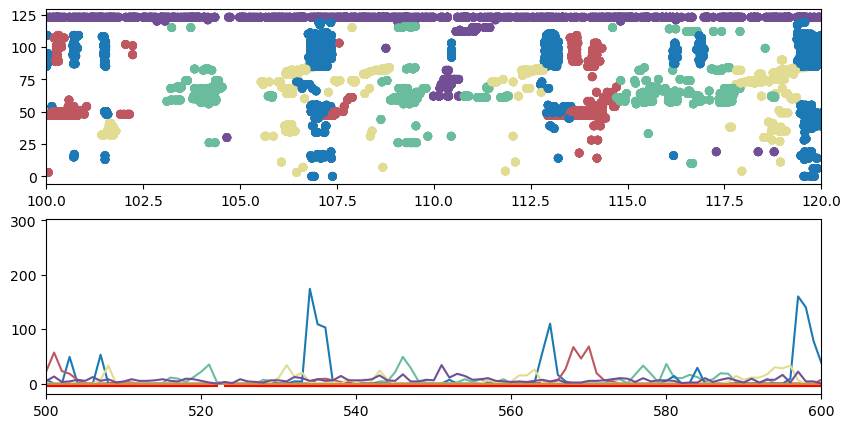

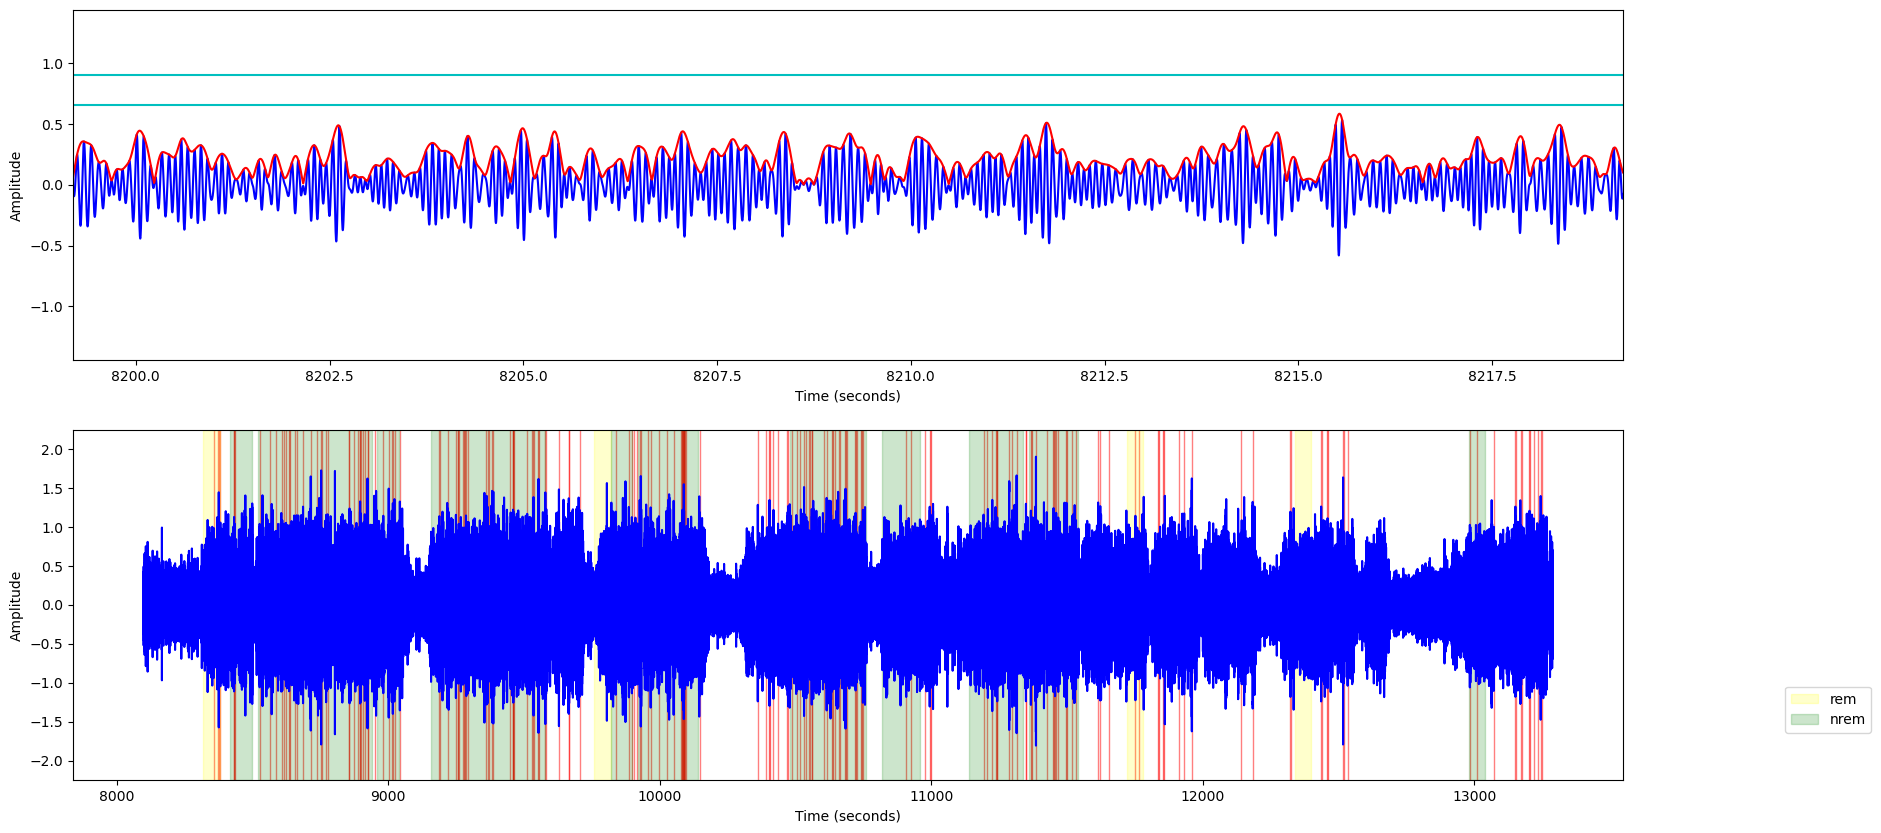

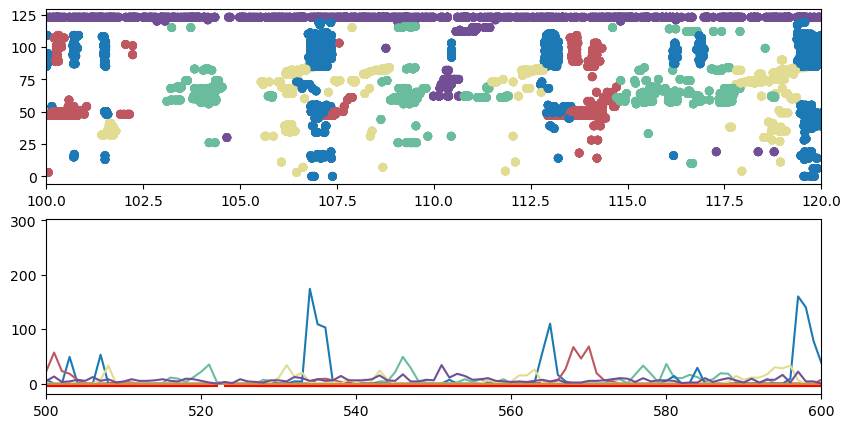

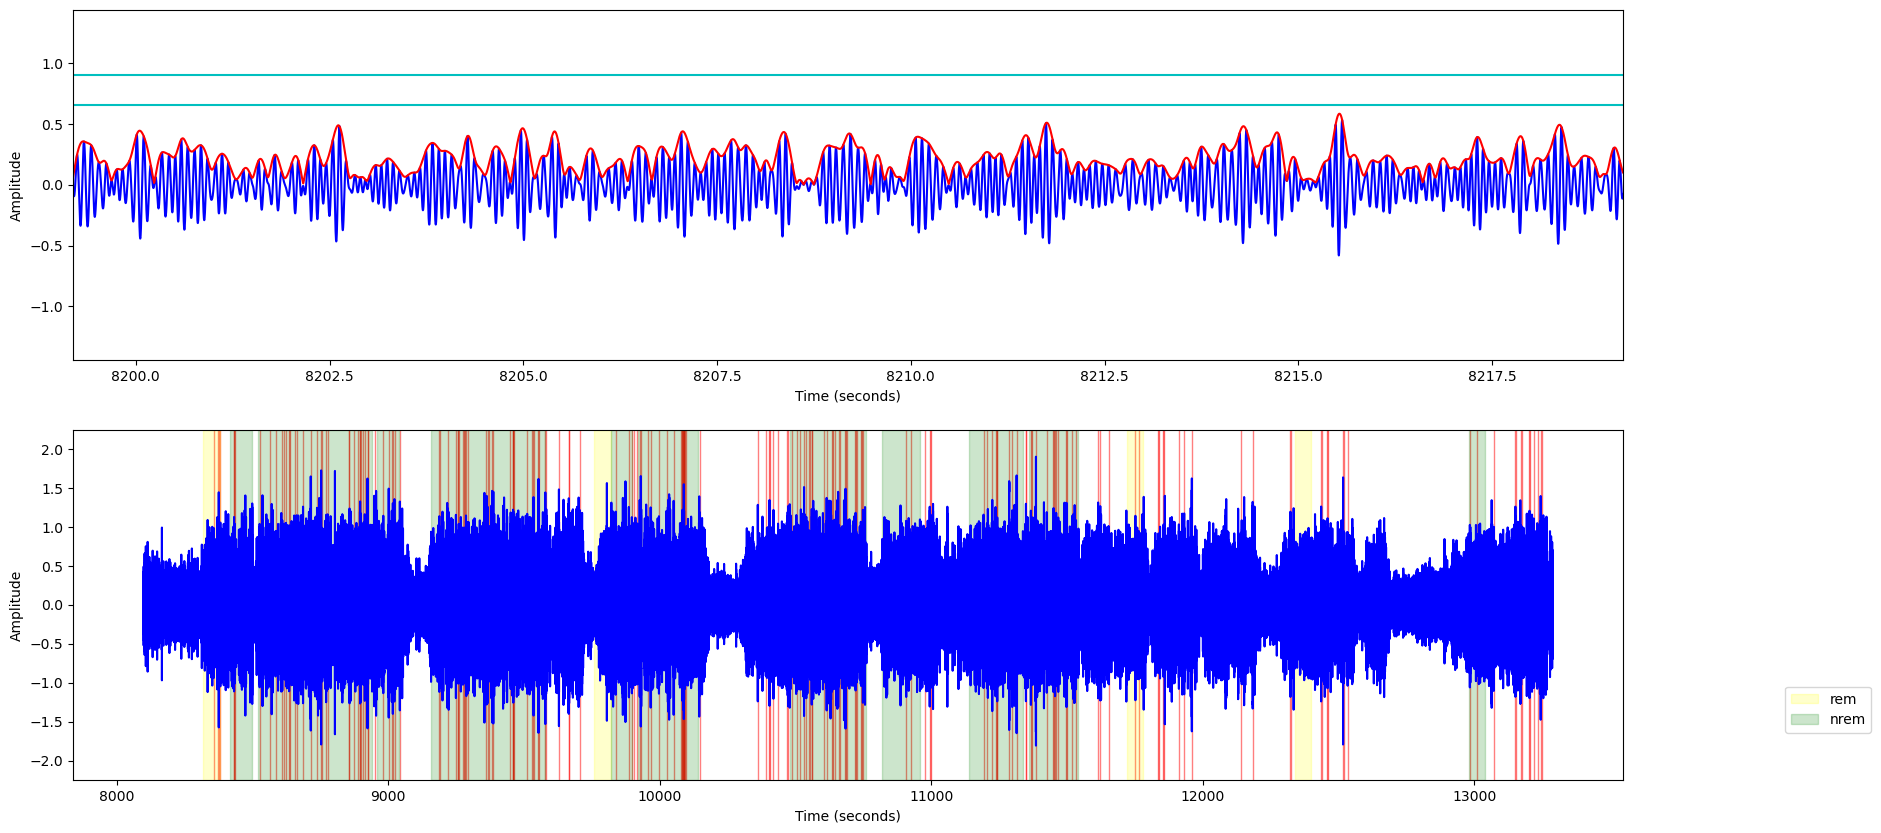

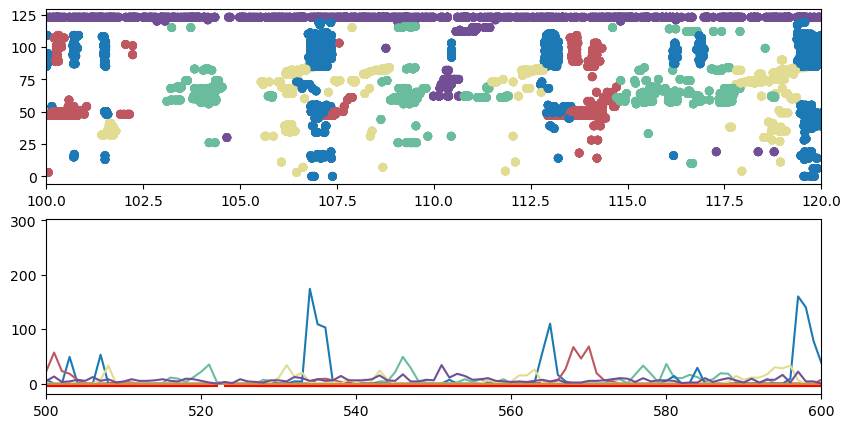

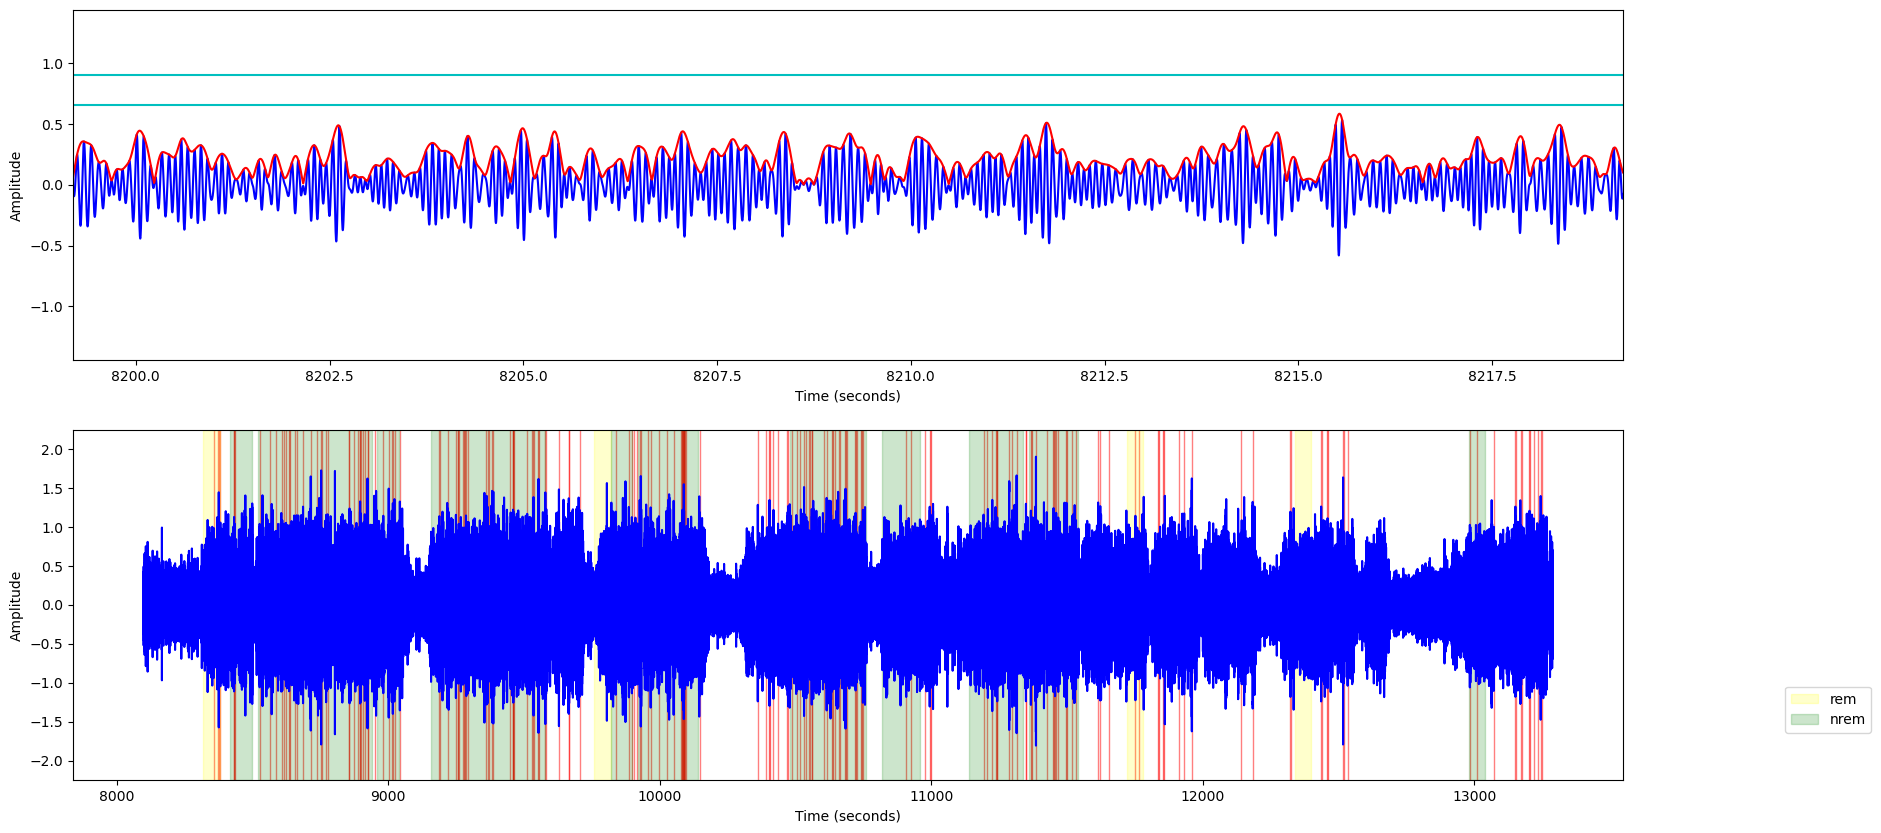

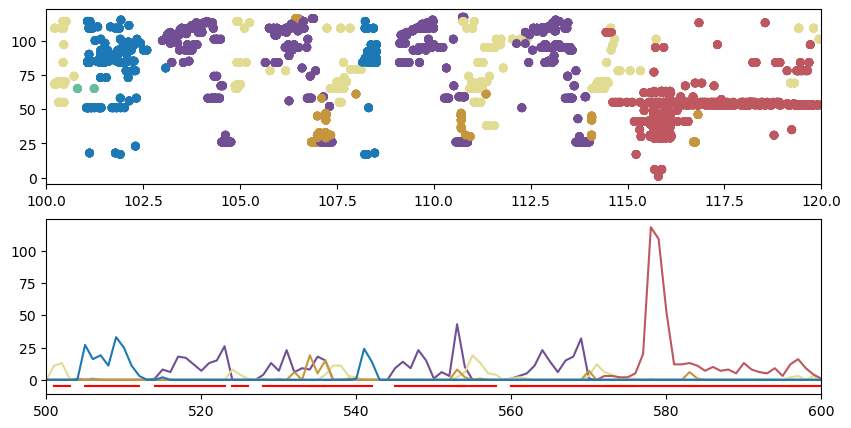

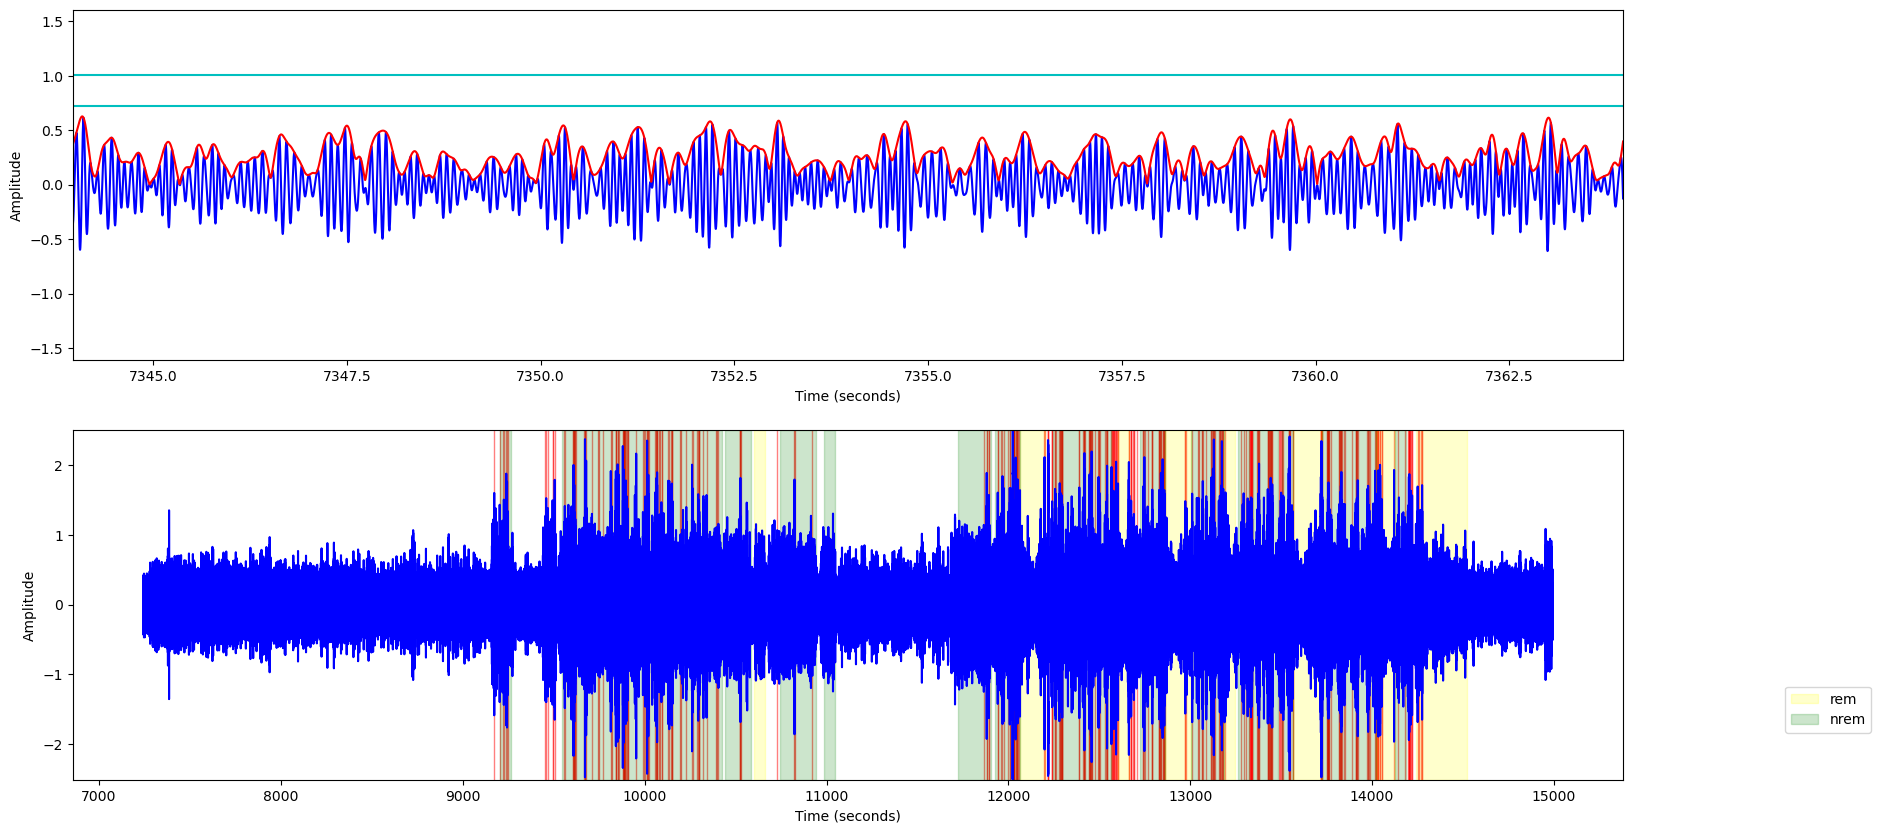

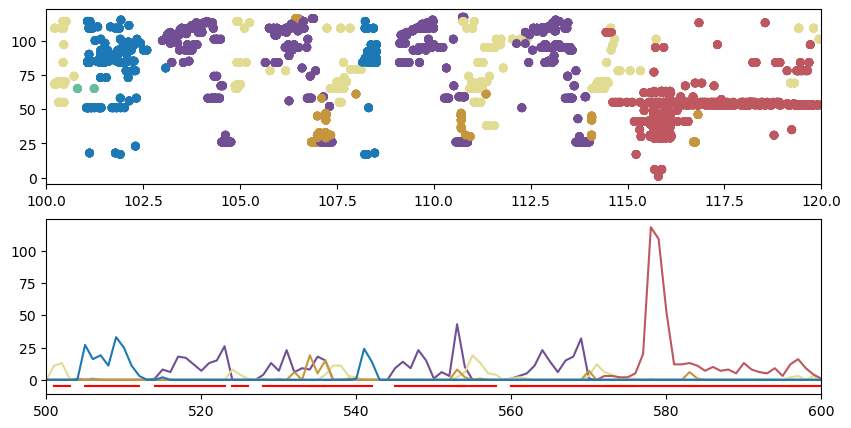

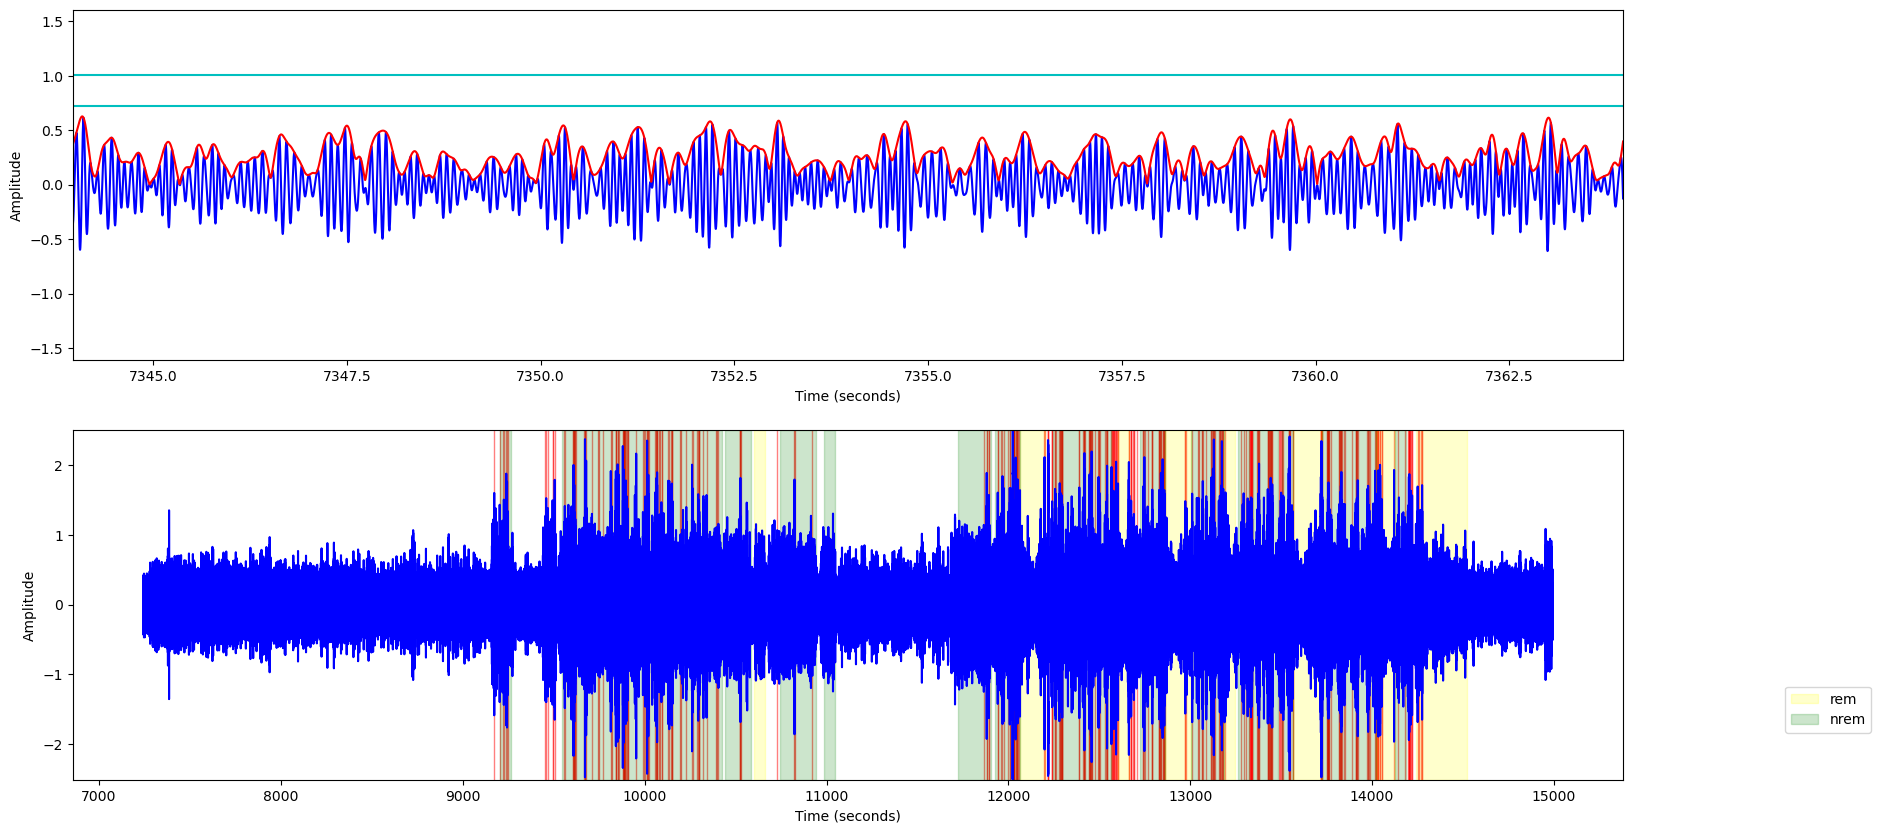

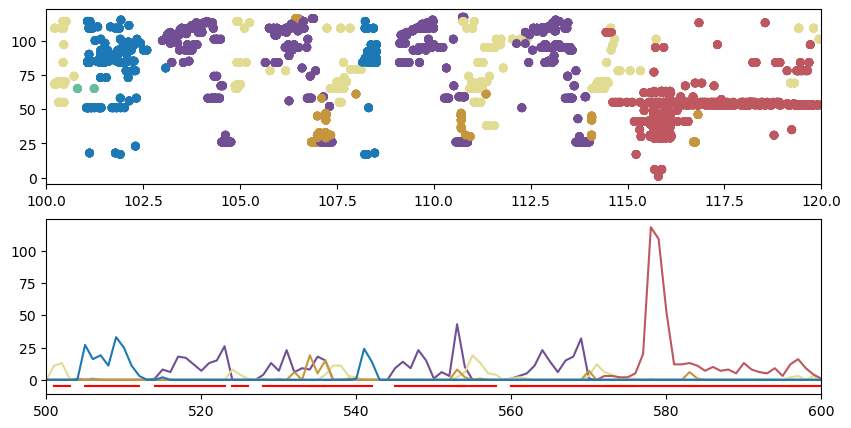

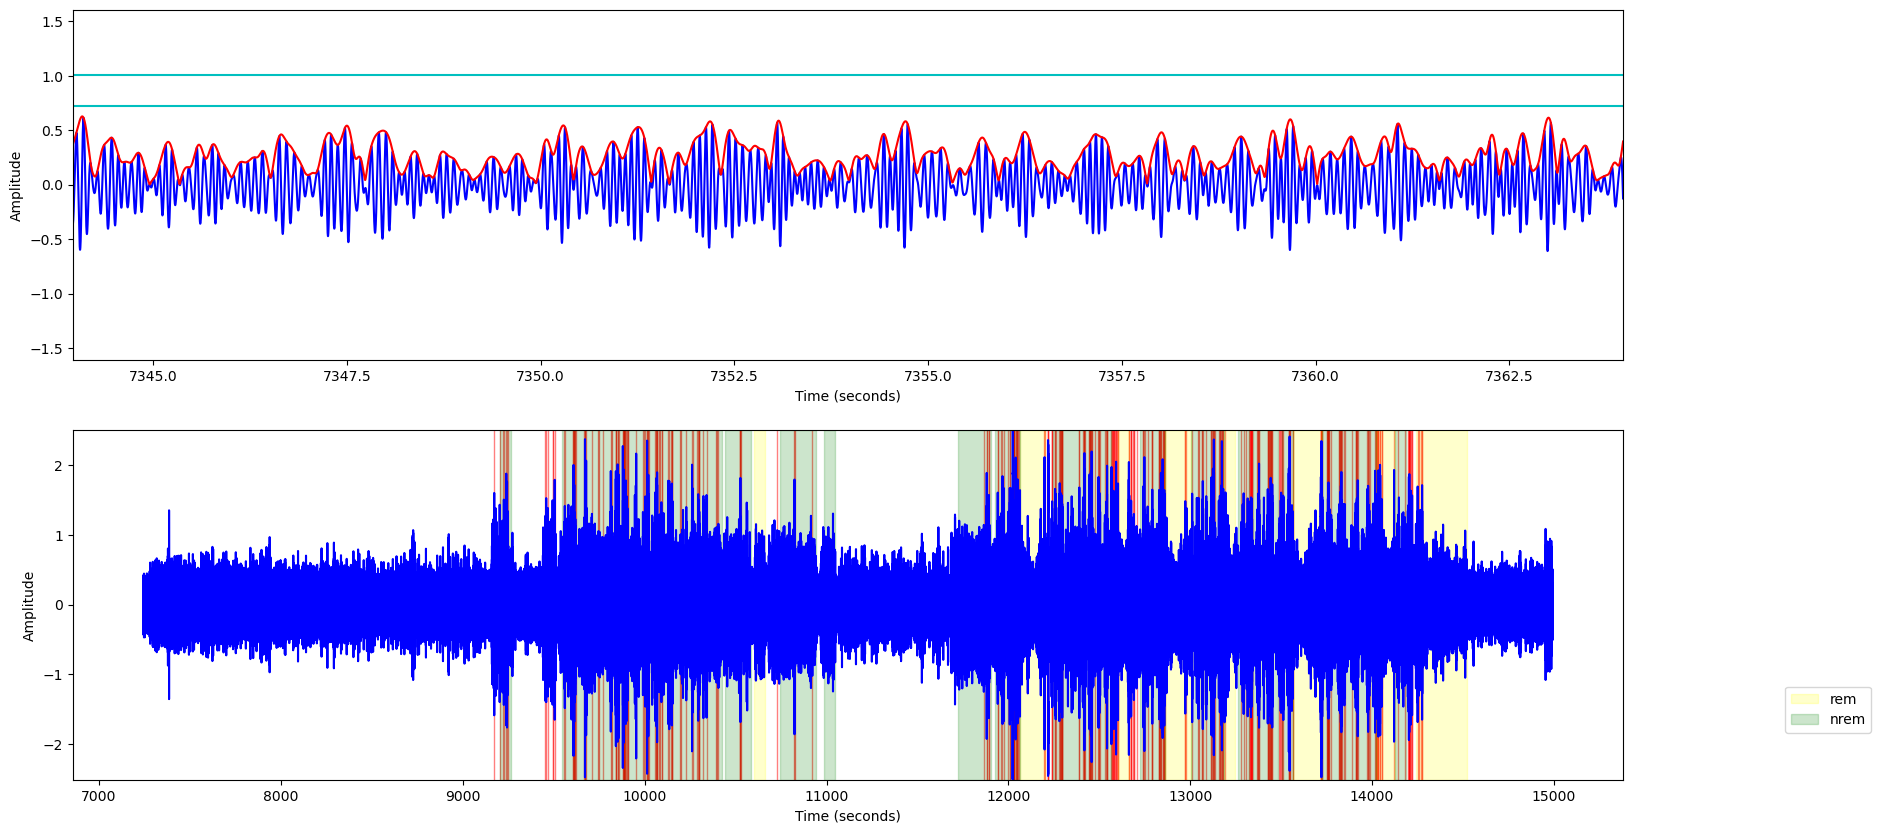

In [ ]:
animals = ['EJT136_1_3','EJT178_2_3','EJT269_1_4','EJT270_1_6','EJT178_2_1','EJT269_1_2','ap5R_1_3','seq006_1_1','seq006_1_4','seq006_1_5','seq006_1_6','seq007_1_1','seq007_1_2','seq006_1_8','seq006_1_9','seq006_1_10','ap5R_1_2','seq006_1_3']
# to be added once ppseq sleep has run! []


# loop over all animals 
for index,mouse in enumerate(animals):
    
    # find organised path
    try: 
        full_org_dat_path = find_organised_path(mouse,r"Z:\projects\sequence_squad\organised_data\animals\\")
    except:
        full_org_dat_path  = find_organised_path(mouse,r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\")
    print(f'full_org_dat_path: {full_org_dat_path}')
    
    # find replay data path  
    sleep_file = None
    if 'EJT' in mouse:
        search_key =mouse.split('T')[-1]
    else:
        search_key = mouse
    
    for file in os.listdir(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\replay_data\\"):
        if search_key in file:
            sleep_file = os.path.join(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\replay_data\\",file)
    print(f"Loading sleep data from: {sleep_file}")
    
    if sleep_file is None:
        continue
    
    
    replay_data_found = False
    print('----------')
    print(mouse)
    print(index)
    current_mouse_sleep_path = sleep_file
    if '_final_analysis_output' in os.listdir(current_mouse_sleep_path):
        # load in sleep start time 
        sleep_time_point_df = pd.read_csv(remove_last_folder(current_mouse_sleep_path) + '\sleep_time_points.csv')
        current_sleep_start = sleep_time_point_df['approx_sleep_start'][np.where(sleep_time_point_df.mir == search_key)[0][0]]
        params_file = current_mouse_sleep_path + r'\trainingData\\' + 'params_' + search_key + '.json'
        with open(params_file, 'r') as file:
            params = json.load(file)
        time_spans = params['time_span']
        
        # load sequence order
        sequence_order = pd.read_csv(r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\" + r'\sequence_order.csv')
        
        mir_row = None
        for ind, row in sequence_order.iterrows():
            if row.mir in mouse:
                mir_row = row
        seq_order = literal_eval(mir_row.seq_order)
        
    else:
        print('No replay data found for ' + mouse)
        continue
    
    ## find awake path 
    expert_awake_ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
    learning_awake_ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"
    other_sleep_ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\prioritisation_data\awake\\"
        
    awake_ppseq_base_path = find_awake_ppseq_base_path(search_key,expert_awake_ppseq_path)
    if awake_ppseq_base_path is None:
        awake_ppseq_base_path = find_awake_ppseq_base_path(search_key,learning_awake_ppseq_path)
    if awake_ppseq_base_path is None:
        awake_ppseq_base_path = find_awake_ppseq_base_path(search_key,learning_awake_ppseq_path)
    print(f'Awake PPSeq base path: {awake_ppseq_base_path}')
    
    
    

    # initialize lists to hold data across chunks 
    #1
    chunk_rpm = []
    #2
    chunk_event_lens = []
    #3
    regression_df = pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
    #4
    total_seqs_chunk = []
    # 6+7
    num_spikes_chunk = []
    num_neurons_chunk = []
    #8 
    coactive_total_per_chunk = []
    overall_total_per_chunk  = []
    #9
    seq_ordered_total_across_chunks = []
    seq_misordered_total_across_chunks = []
    #10
    seq_by_seq_awake_neuron_consistency_per_chunk = []
    #11
    linkage_distances_per_chunk = []
    
    current_mouse_replay_path = current_mouse_sleep_path + '\\_final_analysis_output'
    ## loop across all chunk files ################################
    for chunk_number,file in enumerate(os.listdir(current_mouse_replay_path)):
        if 'chunk' in file:
            print(file)
            current_data_path = current_mouse_replay_path + '\\' + file + '\\'
            chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
            data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            
            ###### FILTERING AND MASKING ##################################################################''
            ## filter this data for sequential ordering
            sequential_condition = data.ordering_classification == 'sequential'
            # filter is set up so that any true will carry forward 
            filtered_chunk_data = data[sequential_condition].reset_index()
            
            ## REM / NREM times only
            # load in sleep state scoring
            nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(search_key)
            # get relevant rem/nrem times for chunk
            chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
            chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
            # get spike times relative to chunk:
            chunk_number = int(file.split('_')[0][-1])
            chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            # make relative to start of chunk
            fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
            # find inds of spike times that are in nrem and rem periods:
            idx  = []
            for start,end in chunk_nrem_times + chunk_rem_times:
                idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
            # filter the data frame, only keeping the rows in idx
            filtered_chunk_data = filtered_chunk_data.iloc[idx]
            filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
            # get rid of the stupid unnamed columns
            filtered_chunk_data = filtered_chunk_data.loc[:, ~filtered_chunk_data.columns.str.startswith('Unnamed')]
            
            #### keep only the seq types that are in the sequence order
            keep_inds = []
            for i,seq_type in enumerate(filtered_chunk_data['cluster_seq_type'].values):
                if int(seq_type)+1 in seq_order:
                    keep_inds += [i]
            filtered_chunk_data = filtered_chunk_data.loc[keep_inds].reset_index(drop=True)
                        
            # 1. REACTIVATION PER MINUTE: #######################################################################
            seq_rpm = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data= seq_chunk_data.reset_index(drop=True)
                seq_rpm += [reactivation_per_minute(seq_chunk_data, chunk_time)]
            chunk_rpm += [seq_rpm]
              
            # 2. REACTIVATION EVENT LENGTH #######################################################################
            seq_lens = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data= seq_chunk_data.reset_index(drop=True)
                seq_lens += [list(seq_chunk_data.event_length.values)]
            chunk_event_lens += [seq_lens]
            
            #3.4. WARP #######################################################################
            current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'
            # load in regression dfs
            df_load = pd.read_csv(current_data_path_temporal_structre+'regression_df.csv',index_col=0)
            df_load['mouse'] = [mouse]*len(df_load)
            #concat:
            regression_df = pd.concat((regression_df,df_load),axis =0)

            #5. RELATIVE OVERALL PROPORTION ########################################################################
            total_seqs = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data= seq_chunk_data.reset_index(drop=True)
                total_seqs += [len(seq_chunk_data)]
            total_seqs_chunk += [total_seqs]
            
            #6 + 7 .  SPIKES + UNITS PER EVENT ########################################################################
            num_spikes_perseq = []
            num_neurons_perseq = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data= seq_chunk_data.reset_index(drop=True)
                num_spikes = []
                num_neurons = []
                for i in range(len(seq_chunk_data)):
                    num_spikes +=[len(literal_eval(seq_chunk_data['cluster_spike_times'].values[i]))]
                    num_neurons += [len(np.unique(literal_eval(seq_chunk_data['cluster_neurons'].values[i])))]
                num_spikes_perseq += [[num_spikes]]
                num_neurons_perseq += [[num_neurons]]
            num_spikes_chunk += [num_spikes_perseq]
            num_neurons_chunk += [num_neurons_perseq]
            
            # 8. COACTIVE EVENTS ########################################################################
            # filter for all task related seqs
            task_seq_only_data = filtered_chunk_data.loc[filtered_chunk_data.cluster_seq_type.isin(np.array(seq_order) + 1)]
            # refine the clusters
            event_proximity_filter = 0.3 # seconds
            chunk_data_clusters  = refind_cluster_events(task_seq_only_data,event_proximity_filter)
            chunk_data_clusters= chunk_data_clusters.reset_index(drop=True)
            
            # for each sequence get the number of events that were paired with another, and the total number of events - for this chunk 
            coactive_total_per_seq = []
            overall_total_per_seq = []
            for seq_id in seq_order:
                coacitve_tot, overall_tot = find_coactive_pair_rate(chunk_data_clusters,seq_id)
                coactive_total_per_seq += [[coacitve_tot]]
                overall_total_per_seq += [[overall_tot]]
            coactive_total_per_chunk += [coactive_total_per_seq]
            overall_total_per_chunk += [overall_total_per_seq]
            
            # 9 . ORDERING ########################################################################
            
            real_order = np.array(seq_order)+1
            num_dominant_seqs = int(mir_row.dominant_task_seqs)  
            #deal wih the fact that the way I order the sequence messes up the order a bit
            if not len(real_order) == num_dominant_seqs:
                dominant = list(real_order[0:num_dominant_seqs])
                other_ = list(real_order[num_dominant_seqs::])
            else:
                dominant = list(real_order)
                other_ = []

            # if there are coactive clusters 
            if len(chunk_data_clusters.coactive_cluster_group.unique()) < len(chunk_data_clusters):
                multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(task_seq_only_data)
            else:
                multi_cluster_df,meaned_order,fs_order = [],[],[]

            seq_ordered_total_chunk = [] 
            seq_misordered_total_chunk = []
            for seq_id in real_order: 
                # find all the coactive pairs for each sequence and then see if they are ordered or not 
                seq_cluster_pairs = []
                for cluster in meaned_order:
                    for index in range(1,len(cluster)):
                        if cluster[index] == seq_id or cluster[index-1] == seq_id:
                            seq_cluster_pairs += [[cluster[index-1],cluster[index]]]
                ordered = 0
                misordered = 0
                for pair in seq_cluster_pairs:
                    outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
                    if outcome in ['ordered', 'repeat', 'reverse']:
                        ordered += 1
                    elif outcome == 'misordered':
                        misordered += 1
                seq_ordered_total_chunk += [ordered]
                seq_misordered_total_chunk += [misordered]
                
            seq_ordered_total_across_chunks += [seq_ordered_total_chunk]
            seq_misordered_total_across_chunks += [seq_misordered_total_chunk]
            
            
        
            ## 10. Awake neuron spiking consistency
            ### load in awake ppseq data for mouse
            with open(awake_ppseq_base_path + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                unmasked_spikes_df = pickle.load(handle)
                
            with open(awake_ppseq_base_path + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                awake_neuron_order = pickle.load(handle)

            colors = pd.read_pickle(awake_ppseq_base_path + r"\analysis_output\reordered_recolored\\" + 'colors')

                
            #load json
            import json
            params = None
            for file_ in os.listdir(awake_ppseq_base_path + r'\trainingData\\'):
                if 'json' in file_:
                    param_path = os.path.join(awake_ppseq_base_path + r'\trainingData\\', file_)
                    with open(param_path,'r') as f:
                        params = json.load(f)
            awake_time_span = params['time_span'][0]

            # cluster the awake spikes into individual sequence events
            seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120]) 
            ## spit the sequence events into individual sequence types
            seq_events_dict = split_sequence_events(seq_event_dfs)

            seq_by_seq_awake_neuron_consistency = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data = seq_chunk_data.reset_index(drop=True)
                proportion_appeared,neurons_appeared= calcuate_neuron_consistency(seq_id+1, unmasked_spikes_df, seq_events_dict)
                event_by_event_proportion_appeared_in_awake = []
                for event_clust_neurons in seq_chunk_data['cluster_neurons']:
                    event_clust_neurons = literal_eval(event_clust_neurons)
                    event_prop_appeared = []
                    for neuron in event_clust_neurons:
                        if neuron in neurons_appeared:
                            indx = np.where(np.array(neurons_appeared) == neuron)[0][0]
                            event_prop_appeared += [proportion_appeared[indx]]
                    # get the mean proportion for the neurons that appeared in the awake replay
                    event_by_event_proportion_appeared_in_awake += [np.mean(event_prop_appeared)]
                seq_by_seq_awake_neuron_consistency += [event_by_event_proportion_appeared_in_awake]
            seq_by_seq_awake_neuron_consistency_per_chunk += [seq_by_seq_awake_neuron_consistency]
            
            ## 11. SPINDLE LINKAGE ########################################################################
            # SPINDLE IDENTIFICATION 
            # are spindle events linked to replay events? proportion linked
            # how close is closest spindle on av. 

            # load behavioural data
            post_sleep_sync_df = load_sync_file(full_org_dat_path,mouse)

            # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
            sleep_period_ephys_start_time = post_sleep_sync_df.Camera_time_Ephys_Aligned[0]

            spind_path = r'Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\spindle_data\\'+ search_key

            # load in spindle bandpassed data 
            spindle_bandpassed = np.load(spind_path + '\zscored_spindle_bandpassed.npy')

            # find spindle events
            fs = 2500
            min_event_duration = 0.3 #s
            spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
            # plt.savefig(output_path + 'spindle_identification.png')

            # get spindle times
            spindle_start_times = [event['start_time'] for event in spindle_events]
            spindle_end_times = [event['end_time'] for event in spindle_events]

            seq_by_seq_linkage_distance = []
            for seq_id in seq_order:
                seq_chunk_data = filtered_chunk_data.loc[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]
                seq_chunk_data = seq_chunk_data.reset_index(drop=True)
                replay_start_times = [min(literal_eval(times)) for times in seq_chunk_data.cluster_spike_times]
                # replay start times are in chunk time, so convert to general ephys time
                # get spike times relative to chunk:
                chunk_number = int(file.split('_')[0][-1])
                chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
                # # make relative to start of chunk
                replay_start_times_realtive_to_chunk_ephys_time = np.array(replay_start_times) - chunk_start_offset
                # convert to ephys time 
                replay_start_ephys_times = replay_start_times_realtive_to_chunk_ephys_time + chunk_time[0]
                
                seq_by_seq_linkage_distance += [define_spindle_linkage(spindle_start_times,spindle_end_times,replay_start_ephys_times)]
                
            linkage_distances_per_chunk += [seq_by_seq_linkage_distance]
                        
    
 


    
            
            
    ## outside chunk loop
    
    #1. REACTIVATION PER MINUTE 
    seq_event_per_min = []
    for i in range(len(seq_order)):
        seq_event_per_min += [np.mean([item[i] for item in chunk_rpm])]
    #!#
    relative_seq_event_rate_per_min = seq_event_per_min/sum(seq_event_per_min)
    
    #2. REACTIVATION EVENT LENGTH
    #!#
    seq_event_lens = []
    for i in range(len(seq_order)):
        seq_event_lens += [np.nanmean([item for sublist in [item[i] for item in chunk_event_lens] for item in sublist])]
    
        
    #3 + 4. WARP +forward/reverse proportion
    forward_proportion_compared_to_reverse = []
    mean_warp_per_motif = []
    regression_df.reset_index(inplace=True,drop=True)
    for seq_id in seq_order:
        seq_reg_data = regression_df.loc[np.where(regression_df.seq_type == seq_id+1)]
        #!#
        mean_warp_per_motif += [np.mean(seq_reg_data['warp_factor'])]
        if len(seq_reg_data[seq_reg_data. warp_factor < 0]) > 0:
            forward_proportion_compared_to_reverse += [len(seq_reg_data[seq_reg_data. warp_factor > 0])/len(seq_reg_data[seq_reg_data. warp_factor < 0])]
        else:
            forward_proportion_compared_to_reverse += [np.nan]
    # 5. RELATIVE OVERALL PROPORTION
    # motif relative proportion 
    total_seqs = []
    
    for i in range(len(seq_order)):
        total_seqs += [sum([item[i] for item in total_seqs_chunk])]
    #!#
    relative_motif_expression_total = np.array(total_seqs)/sum(total_seqs)
    
    ## 6 + 7. SPIKES + UNITS PER EVENT
    #!# #!#
    mean_spikes_per_seq = []
    mean_neurons_per_seq = []
    for i in range(len(seq_order)):
        mean_spikes_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_spikes_chunk] for item in sublist])]
        mean_neurons_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_neurons_chunk] for item in sublist])]
    
    # 8 . COACTIVE EVENTS
    proportion_events_coactive_per_motif = []
    for i in range(len(seq_order)):
        total_coactivly_paired = sum([item for sublist in [item[i] for item in coactive_total_per_chunk] for item in sublist])
        overall_total = sum([item for sublist in [item[i] for item in overall_total_per_chunk] for item in sublist])
        
        if overall_total == 0:
            coactive_proportion = np.nan
        else:
            coactive_proportion = total_coactivly_paired/overall_total
        #!#
        proportion_events_coactive_per_motif += [coactive_proportion]
        
    # 9 . ORDERING 
    #!#
    ordered_pairs_proportion_per_motif = []
    for i in range(len(seq_order)):
        ordered = (sum([item[i] for item in seq_ordered_total_across_chunks]))
        misordered = (sum([item[i] for item in seq_misordered_total_across_chunks]))
        tot = ordered + misordered
        if tot > 0:
            ordered_pairs_proportion_per_motif += [ordered / tot]
        else:   
            ordered_pairs_proportion_per_motif += [np.nan]   
            
    # 10 Awake neuron consistency  
    #!#
    replay_neuron_awake_consistency_per_motif = []
    for i in range(len(seq_order)):
        consistency_score = []
        for proportion_appeared in [item for sublist in [item[i] for item in seq_by_seq_awake_neuron_consistency_per_chunk] for item in sublist]:
            p = np.array(proportion_appeared)
            Ci = 1 - 2 * p * (1 - p)
            consistency_score += [Ci.mean()]
        replay_neuron_awake_consistency_per_motif += [np.nanmean(consistency_score)] 
        
    # 11+12. spindle linkage 
    #!#
    average_linkage_distances_per_motif = []
    #!#
    proportion_spin_linked_per_motif = []
    for i in range(len(seq_order)):
        seq_linkage_dists = [item for sublist in [item[i] for item in linkage_distances_per_chunk] for item in sublist]
        average_linkage_distances_per_motif += [np.nanmean(seq_linkage_dists)]
        if len(seq_linkage_dists) == 0:
            proportion_spin_linked_per_motif += [np.nan]
        else:
            proportion_spin_linked_per_motif += [len(np.array(seq_linkage_dists)[np.array(seq_linkage_dists) < 1.5])/len(seq_linkage_dists)]
        
        

    #####################################
    ## SAVE THE DATA AND FIGURES
    ##################################### 

    output_df = pd.DataFrame({
    "animal_id":[mouse]*len(relative_seq_event_rate_per_min),
    "seq_id":seq_order,
    "relative_event_rate_per_min_per_seq": relative_seq_event_rate_per_min,
    "mean_event_length_per_seq": relative_seq_event_rate_per_min,
    "forward_proportion_compared_to_reverse":forward_proportion_compared_to_reverse,
    "mean_warp_per_motif":mean_warp_per_motif,
    "relative_motif_expression_total":relative_motif_expression_total,
    "mean_spikes_per_seq" :mean_spikes_per_seq,
    "mean_neurons_per_seq" : mean_neurons_per_seq,
    "proportion_events_coactive_per_motif":proportion_events_coactive_per_motif,
    "ordered_pairs_proportion_per_motif" : ordered_pairs_proportion_per_motif,
    "replay_neuron_awake_consistency_per_motif":replay_neuron_awake_consistency_per_motif,
    "average_linkage_distances_per_motif":average_linkage_distances_per_motif,
    "proportion_spin_linked_per_motif":proportion_spin_linked_per_motif
    })

    base_out_path = r'Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\behaviour_data\\'
    out_p = base_out_path + mouse + r'\replay\\'
    if os.path.isdir(out_p):
        shutil.rmtree(out_p)
    os.makedirs(out_p)
    
    output_df.to_csv(out_p + r'\processed_replay_features.csv',index=False)
    
    print('_______________________________________________________________________________________________')
    print('Saved replay features for ' + mouse)
    print('_______________________________________________________________________________________________')    
            

            




In [33]:
    # get awake ppseq path:
    awake_ppseq_base_path = process_awake_ppseq_path(mir, expert_awake_ppseq_path, learning_awake_ppseq_path)

<function __main__.load_in_sleep_state_scoring(mouse)>

In [31]:
mouse

'EJT149_1_1'

'149_1_1'

In [13]:
os.listdir(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\replay_data\\")

['136_1_3_run_1007023_2048',
 '149_1_1_run_0107023_1535',
 '178_1_6_run_0607023_1548',
 '178_1_7_run_1207023_1350',
 '178_1_8_run_0507023_1028',
 '178_2_1_run_0807023_1631',
 '178_2_2_run_0607023_0956',
 '178_2_3_run_2006023_2004',
 '269_1_2_run_1906023_1423',
 '269_1_4_run_2006023_1200',
 '270_1_6_run_1906023_2327',
 'ap5R_1_3_run_2405025_1905',
 'seq006_1_1_run_0907025_1800',
 'seq006_1_4_run_2805025_0013',
 'seq006_1_5_run_2505025_0247',
 'seq006_1_6_run_2905025_0946',
 'seq007_1_1_run_2605025_2356',
 'seq007_1_2_run_2905025_0509']

In [10]:
os.listdir(learning_awake_ppseq_path)

['268_1_2_run_2906023_0109',
 '269_1_1_run_3006023_0438',
 '269_1_2_run_1906023_1423',
 '269_1_3_run_2806023_1335',
 '270_1_1_run_2006023_0408',
 '270_1_3_run_2006023_1428',
 'ap5R_1_1_run_2605025_1136',
 'ap5R_1_3_run_2405025_1905',
 'seq006_1_1_run_0907025_1800',
 'seq006_1_4_run_2805025_0013',
 'seq006_1_5_run_2505025_0247',
 'seq006_1_6_run_2905025_0946',
 'seq007_1_1_run_2605025_2356',
 'seq007_1_2_run_2905025_0509',
 'seq007_1_3_run_2905025_0930',
 'sequence_order.csv',
 'sleep_time_points.csv']

In [9]:
os.listdir(expert_awake_ppseq_path)

['136_1_3_run_1007023_2048',
 '136_1_4_run_0707023_0452',
 '148_2_2_run_1007023_1840',
 '149_1_1_run_0107023_1535',
 '178_1_4_run_0807023_1648',
 '178_1_5_run_0507023_2349',
 '178_1_6_run_0607023_1548',
 '178_1_7_run_1207023_1350',
 '178_1_8_run_0507023_1028',
 '178_1_9_run_0607023_0042',
 '178_2_1_run_0807023_1631',
 '178_2_2_run_0607023_0956',
 '178_2_4_run_0407023_2337',
 '269_1_1_run_3006023_0438',
 '269_1_3_run_2806023_1335',
 '269_1_4_run_2006023_1200',
 '269_1_7_run_1906023_0852',
 '270_1_3_run_2006023_1428',
 '270_1_5_run_2006023_0041',
 '270_1_6_run_1906023_2327',
 'seq006_1_11_run_2905025_1007',
 'sequence_order.csv',
 'sleep_time_points.csv']

EJT149_1_1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording1_16-11-2021
full_org_dat_path: Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording1_16-11-2021
EJT178_1_6
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording6_29-03-2022
full_org_dat_path: Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording6_29-03-2022
EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
full_org_dat_path: Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
EJT178_1_8
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording8_31-03-2022
full_org

In [10]:
remove_last_folder(current_mouse_sleep_path)

'Z:\\projects\\sequence_squad\\ppseq_finalised_publication_data\\learning\\postsleep'

In [8]:
mouse

'ap5R_1_3'

In [9]:
sequence_order

,group,mir,dominant_task_seqs,other_task_seqs,seq_order,color_order_names,color_order_codes
0,expert,148_2_2,4.0,0.0,"[0, 3, 5, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
1,expert,136_1_3,4.0,0.0,"[2, 0, 3, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
2,expert,136_1_4,5.0,0.0,"[0, 2, 5, 4, 3]","['red', 'green', 'yellow', 'blue', 'purple']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5' '#724...
3,expert,149_1_1,4.0,0.0,"[5, 0, 4, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
4,expert,149_1_2,5.0,1.0,"[5, 0, 4, 3, 2]","['red', 'green', 'yellow', 'blue', 'purple']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5' '#724...
5,expert,149_1_3,NaN,NaN,"[5, 0, 4, 3, 2]","['red', 'green', 'yellow', 'blue', 'purple']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5' '#724...
6,expert,162_1_3,3.0,1.0,"[5, 0, 3]","['red', 'green', 'yellow']",['#BE575F' '#69BD9D' '#E2DC92']
7,expert,178_1_4,4.0,1.0,"[4, 1, 2, 3, 0]","['yellow', 'blue', 'red', 'green', 'purple']",['#E2DC92' '#1C79B5' '#BE575F' '#69BD9D' '#724...
8,expert,178_1_5,3.0,1.0,"[5, 1, 4, 0]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
9,expert,178_1_6,4.0,1.0,"[0, 1, 3, 5, 2]","['red', 'yellow', 'blue', 'purple', 'green']",['#BE575F' '#E2DC92' '#1C79B5' '#724F94' '#69B...


In [ ]:
# delete old data in path and make new folder


In [1]:
mouse



NameError: name 'mouse' is not defined

# Garbage

In [ ]:

# def assign_to_group(mouse,expert_mice,hlesion_mice,learning_mice,var_dict):
#     # if session in one of the groups (and define which)   
#     if mouse in list(expert_mice) + list(hlesion_mice) + list(learning_mice):
#         if mouse in expert_mice:
#             var_dict['expert'] += [1]
#             var_dict['hlesion'] += [0]
#             var_dict['learning'] += [0]               
#         elif mouse in hlesion_mice:                
#             var_dict['expert'] += [0]
#             var_dict['hlesion'] += [1]
#             var_dict['learning'] += [0]   
#         elif mouse in learning_mice:                
#             var_dict['expert'] += [0]
#             var_dict['hlesion'] += [0]
#             var_dict['learning'] += [1]   
#     return var_dict

# def get_time_span(dat_path,pp_file,mouse):
#     with open(dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json', 'r') as file:
#         params = json.load(file)
#     time_spans = params['time_span']
#     return time_spans

# def find_useable_mouse_paths(sleep_ppseq_path,useable_mirs,expert_mice,hlesion_mice,learning_mice,var_dict,sleep_start):
#     current_mouse_path = []
#     for run_index,pp_file in enumerate(os.listdir(sleep_ppseq_path)):
#         if not 'sleep_time_points' in pp_file:
#             # current mouse
#             mouse = '_'.join(pp_file.split('_')[0:3])    

#             if mouse in useable_mirs:
                    
#                     # asign to experimental group in var_dict
#                     var_dict = assign_to_group(mouse,expert_mice,hlesion_mice,learning_mice,var_dict)

#                     # load in sleep start time and time span
#                     var_dict['current_sleep_start'] += sleep_start[mouse]
#                     var_dict['time_spans'] += get_time_span(sleep_ppseq_path,pp_file,mouse)

#                     # set path to processed files 
#                     current_mouse_path += [sleep_ppseq_path + pp_file + '\\analysis_output\\']
#                     var_dict['mirs'] += [mouse]
#     return current_mouse_path,var_dict


# def make_filter_masks(data,sequential_filter,nrem_filter,rem_filter,sleep_filters_on,background_only):
#     ## filter this data
#     if sequential_filter == True: 
#         sequential_condition = data.ordering_classification == 'sequential'
#     else:
#         sequential_condition = np.array([True]*len(data.ordering_classification))

#     if sleep_filters_on == True:
#         if nrem_filter == True: 
#             nrem_condition = data.nrem_events == 1
#         else:
#             nrem_condition = np.array([False]*len(data.nrem_events))

#         if rem_filter == True: 
#             rem_condition = data.rem_events == 1
#         else:
#             rem_condition = np.array([False]*len(data.rem_events))

#         if background_only == True:
#             rem_condition = data.rem_events == 0
#             nrem_condition = data.nrem_events == 0

#     else:
#         nrem_condition = np.array([True]*len(data))
#         rem_condition = np.array([True]*len(data))
        
#     # filter is set up so that any true will carry forward 
#     filter_mask = sequential_condition * (nrem_condition + rem_condition)
        
#     return filter_mask

# def determine_chunk_mins(chunk_time,sleep_filters_on,nrem_filter,rem_filter,background_only,path):
#     # if sleep_filters_on is false, use all chunk time
#     if sleep_filters_on == False:
#         mins = np.diff(chunk_time)[0]
#     else:
#         # load in state times
#         rem_state_times = np.load(path + 'rem_state_times.npy')
#         nrem_state_times = np.load(path + 'nrem_state_times.npy')
#         if len(rem_state_times) > 0:
#             tot_rem = sum(np.diff(rem_state_times))[0]
#         else:
#             tot_rem = 0
#         if len(nrem_state_times) > 0:
#             tot_nrem = sum(np.diff(nrem_state_times))[0]
#         else:
#             tot_nrem = 0

#         # if background then use all non rem and non nrem times
#         if background_only:
#             mins = np.diff(chunk_time)[0] - (tot_rem+tot_nrem)
#         else:
#             # if both, use both 
#             if nrem_filter == True and rem_filter == True:
#                 mins = tot_rem+tot_nrem
#             elif nrem_filter == True and rem_filter == False:
#                 mins = tot_nrem
#             elif nrem_filter == False and rem_filter == True:
#                 mins = tot_rem
#     # convert to mins            
#     mins = mins/60
    
#     return mins

# def cluster_events(start_times, end_times, threshold):
#     clusters = []
#     for i in range(len(start_times)):
#         event_added = False
#         for cluster in clusters:
#             for index in cluster:
#                 if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
#                     cluster.append(i)
#                     event_added = True
#                     break
#             if event_added:
#                 break
#         if not event_added:
#             clusters.append([i])
#     return clusters

# def relative_dict(input_dict):
#     total_sum = sum(input_dict.values())
#     relative_dict = {key: value / total_sum for key, value in input_dict.items()}
#     return relative_dict

# def refind_cluster_events(filtered_chunk_data,event_proximity_filter):
    
#     ### ignore the origonal clusterg rosp and remake them: 
#     start_times = filtered_chunk_data.first_spike_time.values
#     end_times = filtered_chunk_data.last_spike_time.values

#     clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

#     cluster_group = np.zeros(len(filtered_chunk_data))
#     for index,cluster in enumerate(clustered_events):
#         for item in cluster:
#             cluster_group[item] = int(index)
#     filtered_chunk_data['coactive_cluster_group'] = cluster_group
    
#     return filtered_chunk_data



# def logic_machine_for_pair_catagorisation(pair,dominant,other):
#     # if first one in dominant check for ordering:
#     if pair[0] in dominant and pair[-1] in dominant:
#         if pair_in_sequence(pair,dominant):
#             return('ordered')
#         elif pair_in_sequence(pair,dominant[::-1]):
#             return('reverse')
#         elif pair[-1] == pair[0]:
#             return('repeat')
#         elif pair[-1] in dominant:
#             return('misordered') 
#     # if its not these  options then check if it could be in the extra task seqs
#     elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
#         for item in other:
#             if pair[0] in  (dominant + [item]):
#                 if pair_in_sequence(pair,(dominant + [item])):
#                     return('ordered')
#                 elif pair_in_sequence(pair,(dominant + [item])[::-1]):
#                     return('reverse')
#                 elif pair[-1] == pair[0]:
#                     return('repeat')
#                 elif pair[-1] in (dominant + [item]):
#                     return('misordered')  
#         # if not this then check if both are in the extra seqs (and are not a repeat):
#         if pair[0] in other and pair[-1] in other:
#             if not pair[-1] == pair[0]: 
#                 return('ordered')
#     else:
#         # if item 1 is in but item 2 isnt then task to other 
#         if pair[0] in  (dominant + other):
#             if not pair[-1] in  (dominant + other):
#                 return('task to other')
#         # if item 2 is in but item 1 isnt then other to task 
#         elif not pair[0] in  (dominant + other):
#             if pair[-1] in  (dominant + other):
#                 return('other to task')
#             else:
#                 return('other')
#     return print('ERROR!')

# def pair_in_sequence(pair, sequence):
#     for i in range(len(sequence) - 1):
#         if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
#             return True
#         # because its ciruclar:
#         elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
#             return True
#     return False

# def calculate_ordering_amounts(meaned_order,dominant,other_):
#     ordered = 0
#     misordered = 0
#     other = 0
#     for cluster in meaned_order:
#         for ind,item in enumerate(cluster):
#             if not ind == len(cluster)-1:
#                 pair = [item,cluster[ind+1]]
#                 outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
#                 if outcome in ['ordered', 'repeat', 'reverse']:
#                     ordered += 1
#                 elif outcome == 'misordered':
#                     misordered += 1
#                 else:
#                     other +=1
#     return ordered,misordered,other

# def all_motifs_proportion_coactive(multi_cluster_df):
#     motif_motif_coative_events = []
#     for seq_type in range(1,7):
#         motif_cluster_groups = multi_cluster_df[multi_cluster_df['cluster_seq_type'] == seq_type].new_cluster_group
#         if not len(motif_cluster_groups) == 0:
#             coative_motif_events = len(motif_cluster_groups)
#         else:
#             coative_motif_events = 0
#         motif_motif_coative_events += [coative_motif_events]
#     return motif_motif_coative_events

# def motif_by_motif_ordering(meaned_order,real_order,dominant,other_):

#     all_motifs_fs_task_related_ordered = []
#     all_motifs_fs_task_related_misordered = []
#     all_motifs_fs_task_related_other = []

#     for motif_type in range(1,7):
#         ordered = 0
#         misordered = 0
#         other = 0
        
#         if motif_type in real_order:
#             for cluster in meaned_order:
#                 for ind,item in enumerate(cluster):
#                     if not ind == len(cluster)-1:
#                         pair = [item,cluster[ind+1]]
#                         if motif_type in pair:
#                             outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
#                             if outcome in ['ordered', 'repeat', 'reverse']:
#                                 ordered += 1
#                             elif outcome == 'misordered':
#                                 misordered += 1
#                             else:
#                                 other +=1  
                                
#             all_motifs_fs_task_related_ordered += [ordered]
#             all_motifs_fs_task_related_misordered += [misordered]
#             all_motifs_fs_task_related_other += [other]
#         else:
#             all_motifs_fs_task_related_ordered += ['nan']
#             all_motifs_fs_task_related_misordered += ['nan']
#             all_motifs_fs_task_related_other += ['nan']

#     return all_motifs_fs_task_related_ordered,all_motifs_fs_task_related_misordered,all_motifs_fs_task_related_other

# def coactive_rate(filtered_chunk_data):
#     # how mnay coacitve in chunk: 
#     current_coactive_freqs_chunk = {}
#     for cluster in filtered_chunk_data.coactive_cluster_group.unique():
#         num = list(filtered_chunk_data.coactive_cluster_group.values).count(cluster)
#         if num in current_coactive_freqs_chunk:
#             current_coactive_freqs_chunk[num] += 1
#         else:
#             current_coactive_freqs_chunk[num] = 1
            
#     # total single events that are cocaitve with at least one other
#     cocative_total = 0
#     overall_total = 0
#     for item in list(current_coactive_freqs_chunk):
#         if item > 1:
#             cocative_total += current_coactive_freqs_chunk[item]
#         overall_total += current_coactive_freqs_chunk[item] * item

#     # coactive_lengths (only coactive, ignore single events)
#     coactive_len_per_chunk =[]
#     for item in current_coactive_freqs_chunk:
#         if item > 1:
#             coactive_len_per_chunk += current_coactive_freqs_chunk[item] * [item]


#     return cocative_total,coactive_len_per_chunk,overall_total

# def empty_chunk_vars():
#     ## set chunk vars 
#     chunk_vars = {"chunk_reactivations" : [],
#                 "chunk_mins" : [],
#                 "chunk_motif_type_reactivations" : [],
#                 "mean_spikes_per_event" : [],
#                 "motif_by_motif_mean_spikes_per_event" : [],
#                 "mean_units_per_event" : [],
#                 "motif_by_motif_mean_units_per_event" : [],
#                 "chunk_event_lengths" : [],
#                 "motif_event_lenghts" : [],
#                 "total_single_events_coacitvely_paired" : [],
#                 "coactive_lenghts" : [],
#                 "overall_total_coactive_or_single_cluster_events" : [],
#                 "meaned_order_task_related_ordered":[],
#                 "meaned_order_task_related_misordered":[],
#                 "meaned_order_task_related_other":[],
#                 "fs_order_task_related_ordered":[],
#                 "fs_order_task_related_misordered":[],
#                 "fs_order_task_related_other":[],
#                 "normalised_task_related_total":[],
#                 "normalised_non_task_related_total":[],
#                 "all_motifs_total_coactive":[],
#                 "meaned_ordering_all_motifs_task_related_ordered":[],
#                 "meaned_ordering_all_motifs_task_related_misordered":[],
#                 "meaned_ordering_all_motifs_task_related_other":[],
#                 "fs_ordering_all_motifs_task_related_ordered":[],
#                 "fs_ordering_all_motifs_task_related_misordered":[],
#                 "fs_ordering_all_motifs_task_related_other":[],
                
#                 "normalised_task_related_total":[],
#                 "normalised_non_task_related_total":[],
                                
                

#     }
#     return chunk_vars

In [ ]:

# ordering of coactive?
if not chunk_vars['total_single_events_coacitvely_paired'][chunk_index] == 0:
    multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(filtered_chunk_data)
else:
    multi_cluster_df,meaned_order,fs_order = [],[],[]

# pull out sequence order for current mouse
seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == var_dict['mirs'][loop_index]].seq_order.values[0])
num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == var_dict['mirs'][loop_index]].dominant_task_seqs)
real_order = np.array(seq_order)+1

#deal wih the fact that the way I order the sequence messes up the order a bit
if not len(real_order) == num_dominant_seqs:
    dominant = list(real_order[0:num_dominant_seqs])
    other_ = list(real_order[num_dominant_seqs::])
else:
    dominant = list(real_order)
    other_ = []
    
# orderng amounts for mean ordering - this calculated for each pair in the chunk 
ordered,misordered,other = calculate_ordering_amounts(meaned_order,dominant,other_)
chunk_vars['meaned_order_task_related_ordered'] += [ordered]
chunk_vars['meaned_order_task_related_misordered'] += [misordered]
chunk_vars['meaned_order_task_related_other'] += [other]

# orderng amounts for first spike ordering
ordered,misordered,other = calculate_ordering_amounts(fs_order,dominant,other_)
chunk_vars['fs_order_task_related_ordered'] += [ordered]
chunk_vars['fs_order_task_related_misordered'] += [misordered]
chunk_vars['fs_order_task_related_other'] += [other]
### motif by motif:
# does one motif appear more in coactive?
if not chunk_vars['total_single_events_coacitvely_paired'][chunk_index] == 0:
    all_motifs_total_coactive = all_motifs_proportion_coactive(multi_cluster_df)
    chunk_vars['all_motifs_total_coactive'] += [all_motifs_total_coactive]
else:
    chunk_vars['all_motifs_total_coactive'] += [[0,0,0,0,0,0]]

# does one motif appeaer more ordered? 
# # this is only calculated for the task related motifs as the non task dont have an order - thought other catagory still exists for times it was task to non task or other way around 
# meaned ordering 
all_motifs_meaned_ordering_task_related_ordered,all_motifs_meaned_ordering_task_related_misordered,all_motifs_meaned_ordering_task_related_other = motif_by_motif_ordering(meaned_order,real_order,dominant,other_)
chunk_vars['meaned_ordering_all_motifs_task_related_ordered'] += [all_motifs_meaned_ordering_task_related_ordered]
chunk_vars['meaned_ordering_all_motifs_task_related_misordered'] += [all_motifs_meaned_ordering_task_related_misordered]
chunk_vars['meaned_ordering_all_motifs_task_related_other'] += [all_motifs_meaned_ordering_task_related_other]

# first spike ordering 
all_motifs_fs_task_related_ordered,all_motifs_fs_task_related_misordered,all_motifs_fs_task_related_other = motif_by_motif_ordering(fs_order,real_order,dominant,other_)
chunk_vars['fs_ordering_all_motifs_task_related_ordered'] += [all_motifs_fs_task_related_ordered]
chunk_vars['fs_ordering_all_motifs_task_related_misordered'] += [all_motifs_fs_task_related_misordered]
chunk_vars['fs_ordering_all_motifs_task_related_other'] += [all_motifs_fs_task_related_other]

7

In [212]:
num_spikes

[20]

In [205]:
len(literal_eval(seq_chunk_data['cluster_spike_times']))

ValueError: malformed node or string: 10    [2629.9385, 2629.9392, 2629.9454, 2629.9278, 2...
Name: cluster_spike_times, dtype: object

In [200]:
forward_proportion_compared_to_reverse

[2.0714285714285716, 1.18125, 1.2828282828282829, 0.6363636363636364]

In [195]:
len(seq_reg_data[seq_reg_data. warp_factor > 0])

7

In [194]:
len(seq_reg_data[seq_reg_data. warp_factor <= 0])

11

0.3888888888888889

In [ ]:
            ##################################### av. spikes involved
            chunk_vars['mean_spikes_per_event'] += [[len(item) for item in filtered_chunk_data.cluster_spike_times]]
            # per motif
            motif_by_motif_mean_spikes_per_event = []
            for motif_number in range(1,7):
                motif_data = filtered_chunk_data[filtered_chunk_data['cluster_seq_type'] == motif_number]
                motif_by_motif_mean_spikes_per_event += [[len(item) for item in motif_data.cluster_spike_times]]
            chunk_vars['motif_by_motif_mean_spikes_per_event'] += [motif_by_motif_mean_spikes_per_event]  
                    
            ########################################## average units involved 
            chunk_vars['mean_units_per_event'] += [[len(np.unique(ast.literal_eval(item))) for item in filtered_chunk_data.cluster_neurons]]
            motif_by_motif_mean_units_per_event = []
            for motif_number in range(1,7):
                motif_data = filtered_chunk_data[filtered_chunk_data['cluster_seq_type'] == motif_number]
                motif_by_motif_mean_units_per_event += [[len(np.unique(ast.literal_eval(item))) for item in motif_data.cluster_neurons]]
            chunk_vars['motif_by_motif_mean_units_per_event'] += [motif_by_motif_mean_units_per_event]

In [164]:
relative_seq_event_rate_per_min = seq_event_per_min/sum(seq_event_per_min)

In [166]:
seq_event_per_min

[np.float64(nan)]

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_42616\2415183231.py:3: RuntimeWarning: Mean of empty slice
  seq_event_lens += [np.nanmean([item for sublist in [item[i] for item in chunk_event_lens] for item in sublist])]


In [162]:
seq_event_lens

[np.float64(nan),
 np.float64(0.12021244979920481),
 np.float64(nan),
 np.float64(0.027006666666651784)]

In [152]:
[item for sublist in [item[i] for item in chunk_event_lens] for item in sublist]

[]

In [160]:
chunk_event_lens[1][0]

[]

In [150]:
seq_event_lens

[np.float64(nan),
 np.float64(0.12021244979920481),
 np.float64(nan),
 np.float64(0.027006666666651784)]

In [144]:
seq_event_lens


array([], dtype=float64)

In [140]:
flat_chunk_event_lens

[np.float64(0.0531999999999754),
 np.float64(0.0142000000000166),
 np.float64(0.0228999999999928),
 np.float64(0.0275000000000034),
 np.float64(0.0101999999999975),
 np.float64(0.0584999999999809),
 np.float64(0.0175999999999874),
 np.float64(0.0537000000000205),
 np.float64(0.0224000000000046),
 np.float64(0.0378000000000042),
 np.float64(0.0768999999999664),
 np.float64(0.0511999999999943),
 np.float64(0.0912999999999897),
 np.float64(0.1779999999999972),
 np.float64(0.0810999999999921),
 np.float64(0.0736999999999739),
 np.float64(0.0464000000000055),
 np.float64(0.0212000000000216),
 np.float64(0.0372999999999592),
 np.float64(0.031499999999994),
 np.float64(0.1111000000000217),
 np.float64(0.016900000000021),
 np.float64(0.0271999999999934),
 np.float64(0.0158000000000129),
 np.float64(0.0059999999999718),
 np.float64(0.1580000000000154),
 np.float64(0.0815000000000054),
 np.float64(0.0780000000000313),
 np.float64(0.0147999999999797),
 np.float64(0.0375999999999976),
 np.float64(

In [134]:
chunk_event_lens[0]

[[],
 [np.float64(0.0531999999999754),
  np.float64(0.0142000000000166),
  np.float64(0.0228999999999928),
  np.float64(0.0275000000000034),
  np.float64(0.0101999999999975),
  np.float64(0.0584999999999809),
  np.float64(0.0175999999999874),
  np.float64(0.0537000000000205),
  np.float64(0.0224000000000046),
  np.float64(0.0378000000000042),
  np.float64(0.0768999999999664),
  np.float64(0.0511999999999943),
  np.float64(0.0912999999999897),
  np.float64(0.1779999999999972),
  np.float64(0.0810999999999921),
  np.float64(0.0736999999999739),
  np.float64(0.0464000000000055),
  np.float64(0.0212000000000216),
  np.float64(0.0372999999999592),
  np.float64(0.031499999999994),
  np.float64(0.1111000000000217),
  np.float64(0.016900000000021),
  np.float64(0.0271999999999934),
  np.float64(0.0158000000000129),
  np.float64(0.0059999999999718),
  np.float64(0.1580000000000154),
  np.float64(0.0815000000000054),
  np.float64(0.0780000000000313),
  np.float64(0.0147999999999797),
  np.float6

In [ ]:
chunk_rpm
chunk_event_lens

In [106]:
regression_df 

,seq_type,regression_line,filt_rel_spike_times,slope,reactivation_ID,warp_factor,mouse,awake_rel_occurance_times,task_involved
0,1.0,[0.4539199 0.51027892 0.4342718 0.48546027 0...,[0.0448 0.0557 0.041 0.0509 0. 0.0257 0.0...,5.170553,0.0,1.443771,136_1_3,[0.73537798 0.73537798 0.49940425 0.2811263 0...,1.0
1,1.0,[0.62004643 0.39491982 0.37708801 0.23109006 0...,[0. 0.0202 0.0218 0.0349 0.0084 0.0204 0.0...,-11.144881,9.0,-3.111981,136_1_3,[0.87948413 0.87948413 0.30634616 0.30634616 0...,1.0
2,1.0,[0.86585369 0.69513829 0.3929259 0.42906835 0...,[0. 0.0222 0.0615 0.0568 0.0814 0.1038],-7.689883,10.0,-2.147243,136_1_3,[0.87948413 0.87948413 0.21668602 0.23829101 0...,1.0
3,1.0,[ 0.49788529 0.20586617 0.19078031 -0.184211...,[0. 0.0271 0.0285 0.0633 0.0258 0.0096 0.0...,-10.775613,11.0,-3.008870,136_1_3,[0.87948413 0.04104176 0. 0. 0...,1.0
4,1.0,[0.42389077 0.53777263 0.31965993 0.29263711 0...,[0.0059 0. 0.0113 0.0127 0.0246 0.0127 0.0...,-19.302009,17.0,-5.389692,136_1_3,[0.87948413 0.30634616 0.07390482 0.07390482 0...,1.0
...,...,...,...,...,...,...,...,...,...
1201,6.0,[0.59548911 1.01292746 0.40594303 0.42396903 0...,[0.1806 0.5627 0.0071 0.0236 0. 0.0152 0.0...,1.092485,641.0,1.141124,136_1_3,[0.9164957 0.9164957 0.1243793 0.02768056 0...,0.0
1202,6.0,[0.15433603 0.91594778 0.17987242 0.16329616 0...,[0.17 0. 0.1643 0.168 0.1686 0.17 0.1...,-4.480069,644.0,-4.679531,136_1_3,[0.45344187 0.9164957 0.02768056 0.02768056 0...,0.0
1203,6.0,[0.5179733 0.33377115 0.86055995 0.85963789 0...,[0.8174 1.2569 0. 0.0022 0.0041 0.0065 0.1...,-0.419118,645.0,-0.437777,136_1_3,[0.45344187 0.45344187 0.9164957 0.9164957 0...,0.0
1204,6.0,[0.68308293 0.43199044 0.46632788 0.2946407 0...,[0.1086 0.0384 0.048 0. 0.0222 0.0299 0.0...,3.576816,653.0,3.736063,136_1_3,[0.9164957 0.08428787 0.02768056 0.53141627 0...,0.0


In [97]:
seq_rpm

[[array([0.])], [array([1.])], [array([0.])], [array([0.1])]]

In [100]:
len(chunk_event_lens[1])

4

In [90]:
chunk_rpm

[[array([0.]), array([8.3]), array([0.]), array([0.4])],
 [array([0.]), array([5.85]), array([0.]), array([0.375])],
 [array([0.]), array([1.]), array([0.]), array([0.1])]]

,index,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,ordering_classification,rem_events,nrem_events
10,243,2,20,2629.961,2629.9265,0.0345,2629.961,"[2629.9385, 2629.9392, 2629.9454, 2629.9278, 2...","[45.0, 49.0, 49.0, 51.0, 51.0, 51.0, 51.0, 52....",[ 99. 98. 98. 102. 102. 102. 102. 94. 94. ...,229.0,sequential,0,0


In [86]:
filtered_chunk_data

,index,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,ordering_classification,rem_events,nrem_events
0,120,1,6,2596.9444,2596.9095,0.0349,2596.9444,"[2596.9141, 2596.9186, 2596.9418, 2596.9095, 2...","[39.0, 102.0, 103.0, 104.0, 104.0, 104.0]",[84. 62. 61. 60. 60. 60.],120.0,sequential,0,0
1,125,1,6,2610.7238,2610.7146,0.0092,2610.7238,"[2610.7192, 2610.7146, 2610.7207, 2610.7208, 2...","[82.0, 96.0, 102.0, 104.0, 104.0, 107.0]",[33. 57. 62. 60. 60. 82.],125.0,sequential,0,0
2,143,1,29,2651.0848,2650.6180,0.4668,2651.0848,"[2651.0711, 2651.0848, 2650.7495, 2650.6406, 2...","[90.0, 90.0, 96.0, 98.0, 98.0, 98.0, 100.0, 10...",[68. 68. 57. 58. 58. 58. 64. 61. 61. 61. 61. 6...,143.0,sequential,1,0
3,145,1,11,2654.9776,2654.9429,0.0347,2654.9776,"[2654.9429, 2654.9522, 2654.9514, 2654.958, 26...","[30.0, 30.0, 90.0, 92.0, 92.0, 100.0, 104.0, 1...",[67. 67. 68. 75. 75. 64. 60. 60. 83. 83. 82.],145.0,sequential,1,0
4,149,1,8,2669.6853,2669.6668,0.0185,2669.6853,"[2669.6843, 2669.6847, 2669.678, 2669.6778, 26...","[90.0, 98.0, 99.0, 100.0, 100.0, 101.0, 103.0,...",[ 68. 58. 115. 64. 64. 56. 61. 60.],149.0,sequential,1,0
5,151,1,13,2675.5981,2675.3538,0.2443,2675.5981,"[2675.3538, 2675.5296, 2675.4724, 2675.5379, 2...","[30.0, 39.0, 82.0, 101.0, 101.0, 102.0, 102.0,...",[67. 84. 33. 56. 56. 62. 62. 62. 62. 62. 61. 6...,151.0,sequential,1,0
6,155,1,23,2686.8573,2686.4794,0.3779,2686.8573,"[2686.4794, 2686.4908, 2686.5422, 2686.6195, 2...","[40.0, 40.0, 40.0, 40.0, 40.0, 90.0, 90.0, 101...",[59. 59. 59. 59. 59. 68. 68. 56. 62. 62. 62. 6...,155.0,sequential,1,0
7,162,1,12,2705.4332,2705.4055,0.0277,2705.4332,"[2705.418, 2705.4073, 2705.4135, 2705.4151, 27...","[82.0, 90.0, 90.0, 90.0, 90.0, 99.0, 100.0, 10...",[ 33. 68. 68. 68. 68. 115. 64. 64. 64. ...,162.0,sequential,0,0
8,166,1,11,2717.0506,2716.7483,0.3023,2717.0506,"[2716.7483, 2716.9622, 2716.9666, 2716.986, 27...","[101.0, 102.0, 102.0, 102.0, 102.0, 102.0, 102...",[56. 62. 62. 62. 62. 62. 62. 62. 61. 61. 61.],166.0,sequential,0,0
9,169,1,36,2725.5291,2725.4187,0.1104,2725.5291,"[2725.4542, 2725.4187, 2725.4283, 2725.4507, 2...","[35.0, 90.0, 90.0, 90.0, 90.0, 96.0, 98.0, 99....",[ 69. 68. 68. 68. 68. 57. 58. 115. 56. ...,169.0,sequential,0,0


In [85]:
np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)

(array([10]),)

In [84]:
seq_id+1

2

In [83]:
filtered_chunk_data

,index,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,ordering_classification,rem_events,nrem_events
0,120,1,6,2596.9444,2596.9095,0.0349,2596.9444,"[2596.9141, 2596.9186, 2596.9418, 2596.9095, 2...","[39.0, 102.0, 103.0, 104.0, 104.0, 104.0]",[84. 62. 61. 60. 60. 60.],120.0,sequential,0,0
1,125,1,6,2610.7238,2610.7146,0.0092,2610.7238,"[2610.7192, 2610.7146, 2610.7207, 2610.7208, 2...","[82.0, 96.0, 102.0, 104.0, 104.0, 107.0]",[33. 57. 62. 60. 60. 82.],125.0,sequential,0,0
2,143,1,29,2651.0848,2650.6180,0.4668,2651.0848,"[2651.0711, 2651.0848, 2650.7495, 2650.6406, 2...","[90.0, 90.0, 96.0, 98.0, 98.0, 98.0, 100.0, 10...",[68. 68. 57. 58. 58. 58. 64. 61. 61. 61. 61. 6...,143.0,sequential,1,0
3,145,1,11,2654.9776,2654.9429,0.0347,2654.9776,"[2654.9429, 2654.9522, 2654.9514, 2654.958, 26...","[30.0, 30.0, 90.0, 92.0, 92.0, 100.0, 104.0, 1...",[67. 67. 68. 75. 75. 64. 60. 60. 83. 83. 82.],145.0,sequential,1,0
4,149,1,8,2669.6853,2669.6668,0.0185,2669.6853,"[2669.6843, 2669.6847, 2669.678, 2669.6778, 26...","[90.0, 98.0, 99.0, 100.0, 100.0, 101.0, 103.0,...",[ 68. 58. 115. 64. 64. 56. 61. 60.],149.0,sequential,1,0
5,151,1,13,2675.5981,2675.3538,0.2443,2675.5981,"[2675.3538, 2675.5296, 2675.4724, 2675.5379, 2...","[30.0, 39.0, 82.0, 101.0, 101.0, 102.0, 102.0,...",[67. 84. 33. 56. 56. 62. 62. 62. 62. 62. 61. 6...,151.0,sequential,1,0
6,155,1,23,2686.8573,2686.4794,0.3779,2686.8573,"[2686.4794, 2686.4908, 2686.5422, 2686.6195, 2...","[40.0, 40.0, 40.0, 40.0, 40.0, 90.0, 90.0, 101...",[59. 59. 59. 59. 59. 68. 68. 56. 62. 62. 62. 6...,155.0,sequential,1,0
7,162,1,12,2705.4332,2705.4055,0.0277,2705.4332,"[2705.418, 2705.4073, 2705.4135, 2705.4151, 27...","[82.0, 90.0, 90.0, 90.0, 90.0, 99.0, 100.0, 10...",[ 33. 68. 68. 68. 68. 115. 64. 64. 64. ...,162.0,sequential,0,0
8,166,1,11,2717.0506,2716.7483,0.3023,2717.0506,"[2716.7483, 2716.9622, 2716.9666, 2716.986, 27...","[101.0, 102.0, 102.0, 102.0, 102.0, 102.0, 102...",[56. 62. 62. 62. 62. 62. 62. 62. 61. 61. 61.],166.0,sequential,0,0
9,169,1,36,2725.5291,2725.4187,0.1104,2725.5291,"[2725.4542, 2725.4187, 2725.4283, 2725.4507, 2...","[35.0, 90.0, 90.0, 90.0, 90.0, 96.0, 98.0, 99....",[ 69. 68. 68. 68. 68. 57. 58. 115. 56. ...,169.0,sequential,0,0


In [80]:
np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)[0][0]

np.int64(11)

In [72]:
for seq_id in seq_order:
    np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)

In [74]:
filtered_chunk_data[np.where(filtered_chunk_data.cluster_seq_type == seq_id+1)]

InvalidIndexError: (array([10]),)

In [71]:
seq_order

[2, 0, 3, 1]

In [ ]:
for index, mouse in enumerate(list(all_mice_dict)):
    replay_data_found = False
    print('----------')
    print(mouse)
    animals += [mouse]
    print(index)
    if '_final_analysis_output' in os.listdir(all_mice_dict[mouse]['sleep_path']):

        # load in replay data 
        for run_index,pp_file in enumerate(os.listdir(dat_path)):
            if mouse_file in pp_file:
                print(mouse_file)
                # set path to processed files 
                current_mouse_path = dat_path + pp_file + '\\_final_analysis_output'
                print('replay data path found: ' + current_mouse_path)
                replay_data_found = True
                
                # load in sleep start time 
                current_sleep_start = sleep_start[mouse]
                params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_spans = params['time_span']
                            
                break

    if not replay_data_found:
        print('No replay data found for ' + mouse_file)
        continue
    
    # rpm
    chunk_rpm= []
    # event lengths
    chunk_event_lens = []
    # decay 
    chunk_binned_rate,chunk_bins_relative_so = [],[]
    # coactive freqs
    coactive_freqs_chunk  = {}
    # ordered vs misordered
    chunk_ordered_misordered_proportions = []
    # task vs non task related events
    nontask_task_chunk = []
    # awake seq by seq neuron involvements
    chunk_mouse_neuron_rel_awake_positions_reverse = []
    chunk_mouse_neuron_rel_reverse_replay_positions = []
    chunk_mouse_neuron_rel_awake_positions_forwards = []
    chunk_mouse_neuron_rel_forward_replay_positions = []
    
    ## loop across all chunk files ################################
    for chunk_number,file in enumerate(os.listdir(current_mouse_path)):
        if 'chunk' in file:
            print(file)
            current_data_path = current_mouse_path + '\\' + file + '\\'
            chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
            data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            
            ###### FILTERING AND MASKING ##################################################################''
            ## filter this data for sequential ordering
            sequential_condition = data.ordering_classification == 'sequential'
            # filter is set up so that any true will carry forward 
            filtered_chunk_data = data[sequential_condition].reset_index()
            

In [20]:
sleep_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\behaviour_to_replay\processed_data\\" 

useable_mirs  = [ '149_1_2']
# done '136_1_3', '136_1_4', '149_1_1', '149_1_2', '149_1_3','178_1_4', '178_1_5', '178_1_6', '178_1_7','178_1_8','178_1_9', '178_2_1', '178_2_2', '178_2_4', '268_1_10','269_1_4',
#['ap5R_1_1','ap5R_1_2','ap5R_1_3','seq006_1_1','seq006_1_2','seq006_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq006_1_7','seq006_1_8','seq006_1_9','seq006_1_10','seq006_1_11','seq008_1_3']

# load in sleep time points
sleep_time_point_df = pd.read_csv(sleep_ppseq_path + 'sleep_time_points.csv')
# decide when sleep started
sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value
# define mice/sessions in each group    
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values
hlesion_mice = sleep_time_point_df[sleep_time_point_df.group == 'h_lesion'].mir.values
learning_mice = sleep_time_point_df[sleep_time_point_df.group == 'learning'].mir.values


var_dict = {'expert':[],'hlesion':[],'learning' :[],'mirs':[],'current_sleep_start':[], 'time_spans':[]}

#Load in seq order data 
sequence_order_df = pd.read_csv(sleep_ppseq_path+"sequence_order.csv")
# get all the relevant path name and some other data 
current_mouse_path,var_dict = find_useable_mouse_paths(sleep_ppseq_path,useable_mirs,expert_mice,hlesion_mice,learning_mice,var_dict,sleep_start)
# loop across each mouse path:
for loop_index, path in enumerate(current_mouse_path):
    # create empty chunk vars dict
    chunk_vars = empty_chunk_vars()
    
    print(f"run index: {loop_index}, processing {var_dict['mirs'][loop_index]}")

    ## loop across all chunk files
    for chunk_index, file in enumerate(os.listdir(path)):
        if 'chunk' in file:
            print(file)
            path_ = path + '\\' + file + '\\'
            chunk_time = np.load(path_ + 'chunk_time_interval.npy')
            data = pd.read_csv(path_ + 'filtered_replay_clusters_df.csv')
            
            # filter based on the sequential/rem-nrem conditions set above
            filter_mask = make_filter_masks(data,sequential_filter,nrem_filter,rem_filter,sleep_filters_on,background_only)
            filtered_chunk_data = data[filter_mask].reset_index()
            
            # how many reactivations found
            reactivations_found = len(filtered_chunk_data)
            print(reactivations_found)
            
            ####################################### chunk rate per minute: (# this one depends on rem/nrem filter... )
            mins = determine_chunk_mins(chunk_time,sleep_filters_on,nrem_filter,rem_filter,background_only,path_)
            if mins > 0:
                chunk_vars['chunk_reactivations'] += [reactivations_found] 
                chunk_vars['chunk_mins'] += [mins]     
                
            ####################################### replay rate per motif type
            all_motif_type_reactivations = []
            all_motif_type_reactivations_min = []
            all_motif_type_relative_proportion = []
            for seq_type in range(1,7):
                motif_type_reactivations = [len(np.where(filtered_chunk_data.cluster_seq_type.values == seq_type)[0])][0]
                all_motif_type_reactivations += [motif_type_reactivations]
            chunk_vars['chunk_motif_type_reactivations'] += [all_motif_type_reactivations]
            
            ##################################### av. spikes involved
            chunk_vars['mean_spikes_per_event'] += [[len(item) for item in filtered_chunk_data.cluster_spike_times]]
            # per motif
            motif_by_motif_mean_spikes_per_event = []
            for motif_number in range(1,7):
                motif_data = filtered_chunk_data[filtered_chunk_data['cluster_seq_type'] == motif_number]
                motif_by_motif_mean_spikes_per_event += [[len(item) for item in motif_data.cluster_spike_times]]
            chunk_vars['motif_by_motif_mean_spikes_per_event'] += [motif_by_motif_mean_spikes_per_event]  
                    
            ########################################## average units involved 
            chunk_vars['mean_units_per_event'] += [[len(np.unique(ast.literal_eval(item))) for item in filtered_chunk_data.cluster_neurons]]
            motif_by_motif_mean_units_per_event = []
            for motif_number in range(1,7):
                motif_data = filtered_chunk_data[filtered_chunk_data['cluster_seq_type'] == motif_number]
                motif_by_motif_mean_units_per_event += [[len(np.unique(ast.literal_eval(item))) for item in motif_data.cluster_neurons]]
            chunk_vars['motif_by_motif_mean_units_per_event'] += [motif_by_motif_mean_units_per_event]
            
            ########################################### replay length overall 
            chunk_vars['chunk_event_lengths'] += [filtered_chunk_data.event_length.values]
            
            ########################################### replay length per motif 
            motif_event_lenghts = []
            for i in range(1,7):
                motif_event_lenghts += [filtered_chunk_data[filtered_chunk_data.cluster_seq_type == i].event_length.values]
            chunk_vars['motif_event_lenghts'] += [motif_event_lenghts]
            
            ########################################### coactive rate overall
            event_proximity_filter =  0.3 #s (how close events have to be to each other to be clustered together as coacitve 
            # refind the clusters
            filtered_chunk_data  = refind_cluster_events(filtered_chunk_data,event_proximity_filter)
            # how many single evtns coactivly paired? average coactive rate? proportion of global events coactive? 
            cocative_total,coactive_len_per_chunk,overall_total = coactive_rate(filtered_chunk_data)
            chunk_vars['total_single_events_coacitvely_paired'] += [cocative_total]
            chunk_vars['coactive_lenghts'] += [coactive_len_per_chunk]
            chunk_vars['overall_total_coactive_or_single_cluster_events'] += [overall_total]
                    
                    

            # ordering of coactive?
            if not chunk_vars['total_single_events_coacitvely_paired'][chunk_index] == 0:
                multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(filtered_chunk_data)
            else:
                multi_cluster_df,meaned_order,fs_order = [],[],[]

            # pull out sequence order for current mouse
            seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == var_dict['mirs'][loop_index]].seq_order.values[0])
            num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == var_dict['mirs'][loop_index]].dominant_task_seqs)
            real_order = np.array(seq_order)+1

            #deal wih the fact that the way I order the sequence messes up the order a bit
            if not len(real_order) == num_dominant_seqs:
                dominant = list(real_order[0:num_dominant_seqs])
                other_ = list(real_order[num_dominant_seqs::])
            else:
                dominant = list(real_order)
                other_ = []
                
            # orderng amounts for mean ordering - this calculated for each pair in the chunk 
            ordered,misordered,other = calculate_ordering_amounts(meaned_order,dominant,other_)
            chunk_vars['meaned_order_task_related_ordered'] += [ordered]
            chunk_vars['meaned_order_task_related_misordered'] += [misordered]
            chunk_vars['meaned_order_task_related_other'] += [other]
            
            # orderng amounts for first spike ordering
            ordered,misordered,other = calculate_ordering_amounts(fs_order,dominant,other_)
            chunk_vars['fs_order_task_related_ordered'] += [ordered]
            chunk_vars['fs_order_task_related_misordered'] += [misordered]
            chunk_vars['fs_order_task_related_other'] += [other]
            ### motif by motif:
            # does one motif appear more in coactive?
            if not chunk_vars['total_single_events_coacitvely_paired'][chunk_index] == 0:
                all_motifs_total_coactive = all_motifs_proportion_coactive(multi_cluster_df)
                chunk_vars['all_motifs_total_coactive'] += [all_motifs_total_coactive]
            else:
                chunk_vars['all_motifs_total_coactive'] += [[0,0,0,0,0,0]]
            
            # does one motif appeaer more ordered? 
            # # this is only calculated for the task related motifs as the non task dont have an order - thought other catagory still exists for times it was task to non task or other way around 
            # meaned ordering 
            all_motifs_meaned_ordering_task_related_ordered,all_motifs_meaned_ordering_task_related_misordered,all_motifs_meaned_ordering_task_related_other = motif_by_motif_ordering(meaned_order,real_order,dominant,other_)
            chunk_vars['meaned_ordering_all_motifs_task_related_ordered'] += [all_motifs_meaned_ordering_task_related_ordered]
            chunk_vars['meaned_ordering_all_motifs_task_related_misordered'] += [all_motifs_meaned_ordering_task_related_misordered]
            chunk_vars['meaned_ordering_all_motifs_task_related_other'] += [all_motifs_meaned_ordering_task_related_other]
            
            # first spike ordering 
            all_motifs_fs_task_related_ordered,all_motifs_fs_task_related_misordered,all_motifs_fs_task_related_other = motif_by_motif_ordering(fs_order,real_order,dominant,other_)
            chunk_vars['fs_ordering_all_motifs_task_related_ordered'] += [all_motifs_fs_task_related_ordered]
            chunk_vars['fs_ordering_all_motifs_task_related_misordered'] += [all_motifs_fs_task_related_misordered]
            chunk_vars['fs_ordering_all_motifs_task_related_other'] += [all_motifs_fs_task_related_other]

            ########################################### task related vs other rate
            task_seqs = np.array(seq_order)+1
            # mask each condition
            mask = np.isin(filtered_chunk_data.cluster_seq_type.values, task_seqs)
            opposite_mask = ~mask
            task_related = filtered_chunk_data[mask]
            non_task_related = filtered_chunk_data[opposite_mask]

            #  task v nontask overallrate
            chunk_vars['normalised_task_related_total'] += [len(task_related)/len(task_seqs)]
            if len(task_seqs) == 6:
                chunk_vars['normalised_non_task_related_total'] += [0]
            else:
                chunk_vars['normalised_non_task_related_total'] += [len(non_task_related)/(6-len(task_seqs))]
            
            ### extra stuff to add in:
            
            # same but motif by motif
            
            # number of spikes task related 
            # number of units task related
            
            # # coative rate 
            # task_related_number = 0
            # non_task_related_number = 0
            # for coactive_ in meaned_order:
            #     for motif_item in coactive_:
            #         if motif_item in task_seqs:
            #             task_related_number += 1
            #         else:
            #             non_task_related_number += 1
            # # make it relative:
            # task_related_number = task_related_number/len(task_seqs) 
            # non_task_related_number = non_task_related_number/(6-len(task_seqs))
            # proportion_coacitve_event_that_are_task_related = task_related_number/(task_related_number+non_task_related_number)
            # chunk_vars['proportion_coacitve_event_that_are_task_related'] = proportion_coacitve_event_that_are_task_related
            
            # # motif coactive rate for task and non task 
            # # task
            # task_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type.isin(task_seqs)]
            # task_proportion_single_events_coacitvely_paired,task_av_coactive_len_per_chunk,task_proporiton_of_events_coactive = coactive_rate(task_related)
            # # non task:
            # non_task_events = filtered_chunk_data[~filtered_chunk_data.cluster_seq_type.isin(task_seqs)]
            # nontask_proportion_single_events_coacitvely_paired,nontask_av_coactive_len_per_chunk,nontask_proporiton_of_events_coactive = coactive_rate(non_task_related)

            # replay length
            #task v non task
            # motif by motif  
            # spikes involved
            
            # save out to newly made place
            
        ###now do averages for each chunk and save out to a new file
        ########## Calculate averages across chunks/ combine across chunks for each data variable
        out_vars = {}

        # 1 overall event rate 
        if sum(chunk_vars['chunk_reactivations']) == 0:
            out_vars['event_rpm'] = 0
        else:
            out_vars['event_rpm'] = sum(chunk_vars['chunk_reactivations'])/sum(chunk_vars['chunk_mins'])

        # 2 motif by motif event rate 
        out_vars['motif_event_rpm'] = np.sum(chunk_vars['chunk_motif_type_reactivations'],axis = 0)/sum(chunk_vars['chunk_mins'])

        # 3 motif by motif proportion of all events
        out_vars['motif_relative_event_proportion'] = np.sum(chunk_vars['chunk_motif_type_reactivations'],axis = 0)/sum(np.sum(chunk_vars['chunk_motif_type_reactivations'],axis = 0))

        # 4 spikes per replay event
        chunk_spikes_per_event = chunk_vars['mean_spikes_per_event']
        spikes_per_event = [item for sublist in chunk_spikes_per_event for item in sublist]
        out_vars['spikes_per_event'] = spikes_per_event

        # 5 motif by motif spikes per replay event
        motif_by_motif_spikes_per_event = []
        for seq in range(1,7):
            motif_spikes_per_event = []
            for chunk_ in chunk_vars['motif_by_motif_mean_spikes_per_event']:
                motif_spikes_per_event +=chunk_[seq-1]
            motif_by_motif_spikes_per_event += [motif_spikes_per_event]
        out_vars['motif_by_motif_spikes_per_event'] = motif_by_motif_spikes_per_event

        # 6 units per event
        chunk_units_per_event = chunk_vars['mean_units_per_event']
        units_per_event = [item for sublist in chunk_units_per_event for item in sublist]
        out_vars['units_per_event'] = units_per_event

        # 7 motif by motif units per replay event
        motif_by_motif_units_per_event = []
        for seq in range(1,7):
            motif_units_per_event = []
            for chunk_ in chunk_vars['motif_by_motif_mean_units_per_event']:
                motif_units_per_event +=chunk_[seq-1]
            motif_by_motif_units_per_event += [motif_units_per_event]
        out_vars['motif_by_motif_units_per_event'] = motif_by_motif_units_per_event

        # 8 event lengths
        chunk_event_lengths = chunk_vars['chunk_event_lengths']
        event_lengths = [item for sublist in chunk_event_lengths for item in sublist]
        out_vars['event_lengths'] = event_lengths

        # 9 motif by motif event lengths
        motif_by_motif_event_lengths = []
        for seq in range(1,7):
            motif_event_lengths = []
            for chunk_ in chunk_vars['motif_event_lenghts']:
                motif_event_lengths +=list(chunk_[seq-1])
            motif_by_motif_event_lengths += [motif_event_lengths]
        out_vars['motif_by_motif_event_lengths'] = motif_by_motif_event_lengths

        # 10 coactive rate (proportion of single events coacitvly paired)
        if sum(chunk_vars['total_single_events_coacitvely_paired']) == 0:
            out_vars['proportion_single_events_coactivly_paired'] = 0
        else:
            out_vars['proportion_single_events_coactivly_paired'] = sum(chunk_vars['total_single_events_coacitvely_paired'])/sum(chunk_vars['overall_total_coactive_or_single_cluster_events'])


        # 11 number of motifs in each coative group
        out_vars['coactive_group_lengths'] = [item for sublist in chunk_vars['coactive_lenghts']  for item in sublist]

        # 12 meaned order
        # ordered proporiton out of all 
        ordered = sum(chunk_vars['meaned_order_task_related_ordered'])
        misordered = sum(chunk_vars['meaned_order_task_related_misordered'])
        other = sum(chunk_vars['meaned_order_task_related_other'])
        if ordered+misordered+other == 0:
            out_vars['meaned_order_overall_ordered_prop'] = 0
            # ordered proporito out of taks related (ordered/misodered)
            out_vars['meaned_order_task_related_ordered_prop'] = 0
            # other proportion
            out_vars['meaned_order_overall_other_prop'] = 0
        else:
            out_vars['meaned_order_overall_ordered_prop'] = ordered/(ordered+misordered+other)
            # ordered proporito out of taks related (ordered/misodered)
            if ordered+misordered == 0:
                out_vars['meaned_order_task_related_ordered_prop'] = 0
            else:
                out_vars['meaned_order_task_related_ordered_prop'] = ordered/(ordered+misordered)
            # other proportion
            out_vars['meaned_order_overall_other_prop'] = other/(ordered+misordered+other)

        # 13 first spike order
        # ordered proporiton out of all 
        ordered = sum(chunk_vars['fs_order_task_related_ordered'])
        misordered = sum(chunk_vars['fs_order_task_related_misordered'])
        other = sum(chunk_vars['fs_order_task_related_other'])
        if ordered+misordered+other == 0:
            out_vars['fs_order_overall_ordered_prop'] = 0
            # ordered proporito out of taks related (ordered/misodered)
            out_vars['fs_order_task_related_ordered_prop'] = 0
            # other proportion
            out_vars['fs_order_overall_other_prop'] = 0
        else:
            out_vars['fs_order_overall_ordered_prop'] = ordered/(ordered+misordered+other)
            # ordered proporito out of taks related (ordered/misodered)
            if ordered+misordered == 0:
                out_vars['fs_order_task_related_ordered_prop'] = 0
            else:
                out_vars['fs_order_task_related_ordered_prop'] = ordered/(ordered+misordered)
            # other proportion
            out_vars['fs_order_overall_other_prop'] = other/(ordered+misordered+other)

        # 14 motif by motif proportion coactive, what proprotion of each motif is coactive
        out_vars['motif_proportion_coactive'] = np.sum(chunk_vars['all_motifs_total_coactive'],axis = 0)/np.sum(chunk_vars['chunk_motif_type_reactivations'],axis = 0)

        # 15 does one motif appeaer more ordered? Proportion of moitfs that were in ordered events for coactive task related motifs
        # this is only calculated for the task related motifs as the non task dont have an order - thought other catagory still exists for times it was task to non task or other way around 
        ordered_prop = []
        for seq in range(1,7):
            ordered = []
            misordered = []
            other  = []
            for chunk in chunk_vars['meaned_ordering_all_motifs_task_related_ordered']:
                ordered += [chunk[seq-1]]
            for chunk in chunk_vars['meaned_ordering_all_motifs_task_related_misordered']:
                misordered += [chunk[seq-1]]
            for chunk in chunk_vars['meaned_ordering_all_motifs_task_related_other']:
                other += [chunk[seq-1]]
            if not 'nan' in ordered and (sum(ordered)+sum(misordered)+sum(other)) > 0:
                ordered_prop += [sum(ordered)/(sum(ordered)+sum(misordered)+sum(other))]
            else:
                ordered_prop += ['nan']
        out_vars['motif_meaned_ordering_ordered_prop_out_of_all_task_related'] = ordered_prop

        # 16 same but for first spike ordering
        ordered_prop = []
        for seq in range(1,7):
            ordered = []
            misordered = []
            other  = []
            for chunk in chunk_vars['fs_ordering_all_motifs_task_related_ordered']:
                ordered += [chunk[seq-1]]
            for chunk in chunk_vars['fs_ordering_all_motifs_task_related_misordered']:
                misordered += [chunk[seq-1]]
            for chunk in chunk_vars['fs_ordering_all_motifs_task_related_other']:
                other += [chunk[seq-1]]
            if not 'nan' in ordered and (sum(ordered)+sum(misordered)+sum(other)) > 0:
                ordered_prop += [sum(ordered)/(sum(ordered)+sum(misordered)+sum(other))]
            else:
                ordered_prop += ['nan']
        out_vars['motif_fs_ordering_ordered_prop_out_of_all_task_related'] = ordered_prop
        
        if sum(chunk_vars['normalised_non_task_related_total']) == 0:
            out_vars['Ratio_task_related_to_non_task_related_events'] = sum(chunk_vars['normalised_task_related_total'])
        elif sum(chunk_vars['normalised_task_related_total']) == 0:
            out_vars['Ratio_task_related_to_non_task_related_events'] = 0
        else:
            out_vars['Ratio_task_related_to_non_task_related_events'] = sum(chunk_vars['normalised_task_related_total'])/sum(chunk_vars['normalised_non_task_related_total'])


        ####### SAVE OUT THE DATA 

        try: 
            int(var_dict['mirs'][loop_index].split('_')[0])
            current_save_path = out_path + 'EJT' + var_dict['mirs'][loop_index] + '\\' + save_var + '\\'
        except:
            current_save_path = out_path + var_dict['mirs'][loop_index] + '\\' + save_var + '\\'
            

        ## if the path doesnt exist, make a new dir 
        if not os.path.exists(current_save_path):
            os.makedirs(current_save_path)
            
        # convert all np arrays to list
        for key, value in out_vars.items():
            if isinstance(value, np.ndarray):
                out_vars[key] = value.tolist()

        ### save out the out_vars dict
        with open(current_save_path + 'replay_data_variables.json', 'w') as file:
            json.dump(out_vars, file)
            
        # convert all np arrays to list
        for key, value in var_dict.items():
            if isinstance(value, np.ndarray):
                var_dict[key] = value.tolist()
            
        ### save out the var_dict 
        with open(current_save_path + 'general_mouse_info.json', 'w') as file:
            json.dump(var_dict, file)


In [21]:
current_mouse_path

[]